# Credit Risk Scoring
Janhavi Tamhankar


We want to reduce loan defaults while maintaining approval volume.

In this project, we will be using the **German Credit dataset**, sourced from UCI Machine Learning Repository.

Positive class: Bad credit: 1

### Cost assumptions:
* **False Negative (FN)**: Approving a bad borrower.
  * loan default, capital loss
  * **High Cost**
* **False Positive (FP)**: Declining a good borrower.
  * lost interest revenue, customer dissatisfaction.
  * **Lower cost**

Hence, we will want to focus more on identifying False Negatives in order to minimize losses. So, in the absence of exact monetary costs, we assume that approving a high risk applicant (FN) is **five times more costly** than declining a low-risk applicant(FP).





### Key Evaluation Metrics
Credit risk is a class-imbalanced problem, meaning that there are more cases of good credit than cases of bad credit. So, accuracy alone is not a good metric for evaluation since it only considers the ratio of correct predictions regardless of class. In such cases, we use alternative evaluation metrics.

ML interpretation of metrics:
* **ROC-AUC**: Measures the model's ability to distinguish between classes across different thresholds; 0.5 is random, 1 is perfect.
* **Recall (Sensitivity):** TP / (TP + FN). Of all actual positives, how many did the model find?
* **Specificity**: TN / (TN + FP). How many actual negatives were correctly identified?
* **Precision**: TP / (TP + FP). Out of all predicited positives, how many are actually positive?
* **F1-score**: Balances precision and recall into a single value. High F1 score indicates good performance in both precision and recall, preventing the model from being good at only one.

Business interpretation of metrics:
* **ROC-AUC**: Can the model rank risk well?
* **Recall**: Are we catching risky borrowers?
* **Specificity**: Are we not being overly conservative?

### Library imports

In [1]:
RANDOM_STATE = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [2]:
# Importing the dataset
credit_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', sep=' ', header=None)

# Assigning column names to the dataset
credit_df.columns = ['checking_account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account',
                     'employment_status', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property',
                     'age', 'other_installment_plans', 'housing', 'num_existing_credits', 'job', 'dependents', 'telephone', 'foreign_worker', 'credit_rating']

In [ ]:
credit_df.head()

,checking_account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_status,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,num_existing_credits,job,dependents,telephone,foreign_worker,credit_rating
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [ ]:
credit_df.isna().sum()

,0
checking_account_status,0
duration,0
credit_history,0
purpose,0
credit_amount,0
savings_account,0
employment_status,0
installment_rate,0
personal_status_sex,0
other_debtors,0


## Exploratory Data Analysis

In [ ]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account_status  1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_status        1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

In [ ]:
credit_df["credit_rating"].value_counts()

,count
credit_rating,
1,700
2,300


`1: Good, 2: Bad`

The target variable exhibits a clear class imbalance, with 30% of applicants labeled as bad credit. A naive classifier predicting all applicants as good credit would achieve an accuracy of 70%, illustrating why accuracy alone is misleading in this context.

In [3]:
#converting target variable encoding to conventional 0 and 1
credit_df["credit_rating"] = credit_df["credit_rating"].map({1:0,2:1})

In [ ]:
for col in credit_df.columns:
  if credit_df[col].dtype == "object":
    print(f"{col} categories: {credit_df[col].unique()}")

checking_account_status categories: ['A11' 'A12' 'A14' 'A13']
credit_history categories: ['A34' 'A32' 'A33' 'A30' 'A31']
purpose categories: ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
savings_account categories: ['A65' 'A61' 'A63' 'A64' 'A62']
employment_status categories: ['A75' 'A73' 'A74' 'A71' 'A72']
personal_status_sex categories: ['A93' 'A92' 'A91' 'A94']
other_debtors categories: ['A101' 'A103' 'A102']
property categories: ['A121' 'A122' 'A124' 'A123']
other_installment_plans categories: ['A143' 'A141' 'A142']
housing categories: ['A152' 'A153' 'A151']
job categories: ['A173' 'A172' 'A174' 'A171']
telephone categories: ['A192' 'A191']
foreign_worker categories: ['A201' 'A202']


In [ ]:
credit_df.duplicated().sum()

np.int64(0)

In [ ]:
credit_df.describe(include="all")

,checking_account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_status,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,num_existing_credits,job,dependents,telephone,foreign_worker,credit_rating
count,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000,...,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000,1000.000000
unique,4,NaN,5,10,NaN,5,5,NaN,4,3,...,4,NaN,3,3,NaN,4,NaN,2,2,NaN
top,A14,NaN,A32,A43,NaN,A61,A73,NaN,A93,A101,...,A123,NaN,A143,A152,NaN,A173,NaN,A191,A201,NaN
freq,394,NaN,530,280,NaN,603,339,NaN,548,907,...,332,NaN,814,713,NaN,630,NaN,596,963,NaN
mean,NaN,20.903000,NaN,NaN,3271.258000,NaN,NaN,2.973000,NaN,NaN,...,NaN,35.546000,NaN,NaN,1.407000,NaN,1.155000,NaN,NaN,0.300000
std,NaN,12.058814,NaN,NaN,2822.736876,NaN,NaN,1.118715,NaN,NaN,...,NaN,11.375469,NaN,NaN,0.577654,NaN,0.362086,NaN,NaN,0.458487
min,NaN,4.000000,NaN,NaN,250.000000,NaN,NaN,1.000000,NaN,NaN,...,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,0.000000
25%,NaN,12.000000,NaN,NaN,1365.500000,NaN,NaN,2.000000,NaN,NaN,...,NaN,27.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,0.000000
50%,NaN,18.000000,NaN,NaN,2319.500000,NaN,NaN,3.000000,NaN,NaN,...,NaN,33.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,0.000000
75%,NaN,24.000000,NaN,NaN,3972.250000,NaN,NaN,4.000000,NaN,NaN,...,NaN,42.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,1.000000


In [ ]:
# bad credit rating across categories
cat_cols = ["checking_account_status","credit_history","purpose","savings_account",
            "employment_status","personal_status_sex","other_debtors","property",
            "other_installment_plans","housing","job","telephone","foreign_worker"]

for col in cat_cols:
  props = credit_df.groupby(col)["credit_rating"].mean().sort_values(ascending=False)
  print(f"Proportions of {col}: ")
  print(props,"\n")

Proportions of checking_account_status: 
checking_account_status
A11    0.492701
A12    0.390335
A13    0.222222
A14    0.116751
Name: credit_rating, dtype: float64 

Proportions of credit_history: 
credit_history
A30    0.625000
A31    0.571429
A32    0.318868
A33    0.318182
A34    0.170648
Name: credit_rating, dtype: float64 

Proportions of purpose: 
purpose
A46     0.440000
A410    0.416667
A40     0.380342
A45     0.363636
A49     0.350515
A44     0.333333
A42     0.320442
A43     0.221429
A41     0.165049
A48     0.111111
Name: credit_rating, dtype: float64 

Proportions of savings_account: 
savings_account
A61    0.359867
A62    0.330097
A65    0.174863
A63    0.174603
A64    0.125000
Name: credit_rating, dtype: float64 

Proportions of employment_status: 
employment_status
A72    0.406977
A71    0.370968
A73    0.306785
A75    0.252964
A74    0.224138
Name: credit_rating, dtype: float64 

Proportions of personal_status_sex: 
personal_status_sex
A91    0.400000
A92    0.351613


<Axes: >

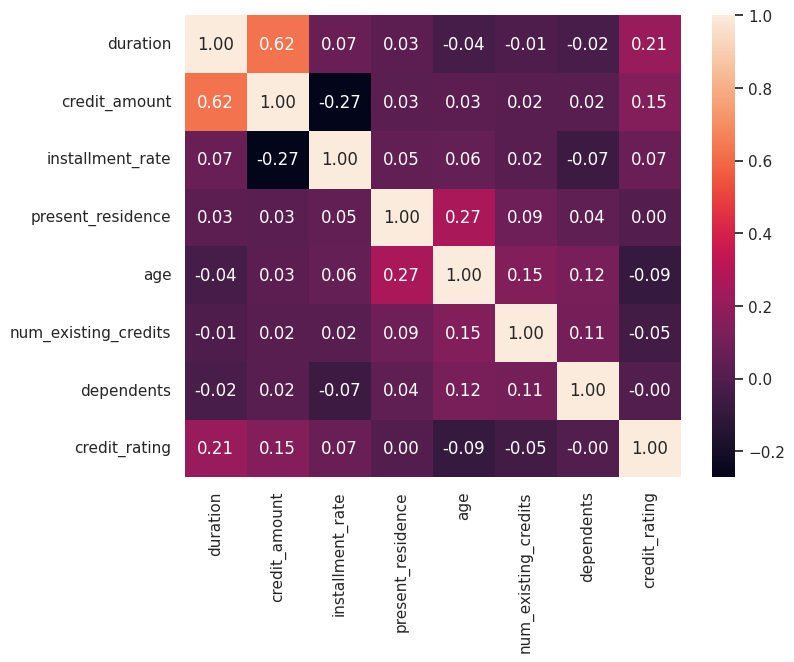

In [ ]:
#correlation heatmap for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(credit_df.select_dtypes(include=np.number).corr(),annot=True, fmt=".2f")

## Cleaning/Preprocessing

In [4]:
#Separating features and target variable
X = credit_df.drop("credit_rating",axis=1)
y = credit_df["credit_rating"].map({1:0,2:1})

## Encoding of Categorical Variables

### Ordinal variables: variables with a natural ordering of categories

**checking_account_status**: Describes the status of the user's current checking account. The categories imply a natural order, which is maintained by creating a numerical mapping.

In [5]:
#checking account status
checking_map = {
  'A11': 0,  # ... < 0 DM  (worst)
  'A12': 1,  # 0 <= ... < 200 DM
  'A13': 2,  # >= 200 DM / salary assignments for >=1 year
  'A14': 3   # no checking account
}

credit_df["checking_account_status"] = credit_df["checking_account_status"].map(checking_map)
credit_df["checking_account_status"].head()

,checking_account_status
0,0
1,1
2,3
3,0
4,0


In [6]:
#credit history mapped as best = highest value
credit_history_map = {
  'A30': 4,  # no credits taken / all credits paid back duly  (best)
  'A31': 3,  # all credits at this bank paid back duly
  'A32': 2,  # existing credits paid back duly till now
  'A33': 1,  # delay in paying off in the past
  'A34': 0   # critical account / other credits existing (worst)
}

credit_df["credit_history"] = credit_df["credit_history"].map(credit_history_map)

In [ ]:
credit_df["credit_history"].value_counts()

,count
credit_history,
2,530
0,293
1,88
3,49
4,40


In [7]:
#savings account/bonds
savings_map = {
  'A61': 0,  # < 100 DM  (lowest)
  'A62': 1,  # 100 <= ... < 500
  'A63': 2,  # 500 <= ... < 1000
  'A64': 3,  # >= 1000
  'A65': 4   # unknown / no savings account  (treat as its own category)
}

credit_df["savings_account"] = credit_df["savings_account"].map(savings_map)

In [8]:
#years of employment
employment_map = {
  'A71': 0,  # unemployed
  'A72': 1,  # < 1 year
  'A73': 2,  # 1 <= ... < 4
  'A74': 3,  # 4 <= ... < 7
  'A75': 4   # >= 7 years
}
credit_df["employment_status"] = credit_df["employment_status"].map(employment_map)

In [9]:
#job seniority and skills
#this is coded as ordinal because job seniority plausibly reduces credit risk
job_map = {
  'A171': 0,  # unemployed/ unskilled - non-resident (worst)
  'A172': 1,  # unskilled - resident
  'A173': 2,  # skilled employee / official
  'A174': 3   # management / self-employed / highly qualified (best)
}

credit_df["job"] = credit_df["job"].map(job_map)

### Binary variables
telephone, foreign worker

In [10]:
credit_df["telephone"] = credit_df["telephone"].map({'A191':0,'A192':1})
credit_df["foreign_worker"] = credit_df["foreign_worker"].map({'A201':1,'A202':0})


In [11]:
credit_df.query("duration >= 60")

,checking_account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_status,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,num_existing_credits,job,dependents,telephone,foreign_worker,credit_rating
29,0,60,1,A49,6836,0,4,3,A93,A101,...,A124,63,A143,A152,2,2,1,1,1,1
134,3,60,2,A43,10144,1,3,2,A92,A101,...,A121,21,A143,A152,1,2,1,1,1,0
255,1,60,1,A43,7418,4,2,1,A93,A101,...,A121,27,A143,A152,1,1,1,0,1,0
332,1,60,2,A40,7408,1,1,4,A92,A101,...,A122,24,A143,A152,1,3,1,0,1,1
373,3,60,0,A40,13756,4,4,2,A93,A101,...,A124,63,A141,A153,1,3,1,1,1,0
374,1,60,3,A410,14782,1,4,3,A92,A101,...,A124,60,A141,A153,2,3,1,1,1,1
616,1,60,1,A43,9157,4,2,2,A93,A101,...,A124,27,A143,A153,1,3,1,0,1,0
637,3,60,1,A43,15653,0,3,2,A93,A101,...,A123,21,A143,A152,2,2,1,1,1,0
672,3,60,2,A40,10366,0,4,2,A93,A101,...,A122,42,A143,A152,1,3,1,1,1,0
677,1,72,2,A43,5595,1,2,2,A94,A101,...,A123,24,A143,A152,1,2,1,0,1,1


### Nominal variables
purpose, personal_status_sex, other_debtors, property, other_installment_plans, housing

Personal status and sex
	      A91 : male   : divorced/separated
	      A92 : female : divorced/separated/married
              A93 : male   : single
	      A94 : male   : married/widowed
	      A95 : female : single


In [12]:
#we can separate sex into its own category and have marital status as a separate category.
#sex: male=0, female=1
sex_map = {'A91':0, 'A92':1,'A93':0,'A94':0,'A95':1}
marital_status_map = {'A91':'divorced_sep','A92':"divorced_sep_married",'A93':'single','A94':'married_widowed',"A95":'single'}

credit_df["sex"] = credit_df["personal_status_sex"].map(sex_map)
credit_df["marital_status"] = credit_df["personal_status_sex"].map(marital_status_map)

In [13]:
credit_df = credit_df.drop("personal_status_sex",axis=1)

In [14]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account_status  1000 non-null   int64 
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   int64 
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   int64 
 6   employment_status        1000 non-null   int64 
 7   installment_rate         1000 non-null   int64 
 8   other_debtors            1000 non-null   object
 9   present_residence        1000 non-null   int64 
 10  property                 1000 non-null   object
 11  age                      1000 non-null   int64 
 12  other_installment_plans  1000 non-null   object
 13  housing                  1000 non-null   object
 14  num_existing_credits     1000 non-null   

In [15]:
#mapping appropriate column names for interpretability
purpose_map = {"A40" : 'car(new)',
               'A41' : 'car(used)',
               'A42' : 'furniture/equipment',
               'A43' : 'radio/tv',
	             'A44' : 'appliances',
	             'A45' : 'repairs',
               'A46' : 'education',
               'A47' : 'vacation',
               'A48' : 'retraining',
               'A49' : 'business',
               'A410' : 'others'
}

other_debtors_map = {
    'A101' : 'none',
	  'A102' : 'coapplicant',
	  'A103' : 'guarantor'
}

property_map = {
    'A121' : 'real estate',
	  'A122' : 'life insurance',
    'A123' : 'car_other',
	  'A124' : 'unknown'
}

installment_plans_map = {
    'A141' : 'bank',
	  'A142' : 'stores',
	  'A143' : 'none'
}

housing_map = {
    'A151' : 'rent',
	  'A152' : 'own',
	  'A153' : 'free',
}

credit_df["purpose"] = credit_df["purpose"].map(purpose_map)
credit_df["other_debtors"] = credit_df["other_debtors"].map(other_debtors_map)
credit_df["property"] = credit_df["property"].map(property_map)
credit_df["other_installment_plans"] = credit_df["other_installment_plans"].map(installment_plans_map)
credit_df["housing"] = credit_df["housing"].map(housing_map)

credit amount is positively correlated to duration,
credit rating is slightly positively correlated to duration,
age and present residence

<Axes: xlabel='duration', ylabel='credit_amount'>

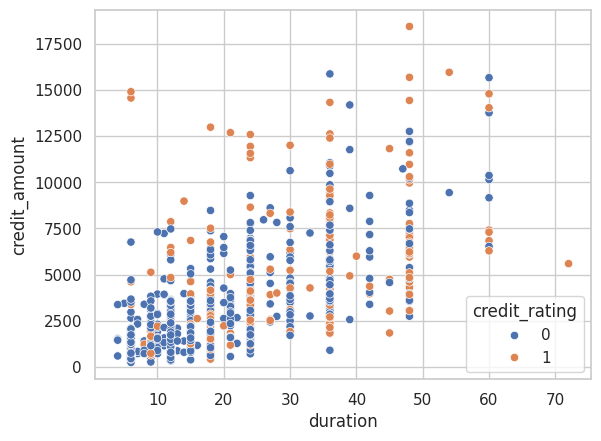

In [16]:
sns.scatterplot(x="duration",y="credit_amount",hue="credit_rating",data=credit_df)

There is a slight linear positive trend - as duration increases, credit amount also increases.

<Axes: xlabel='credit_rating', ylabel='count'>

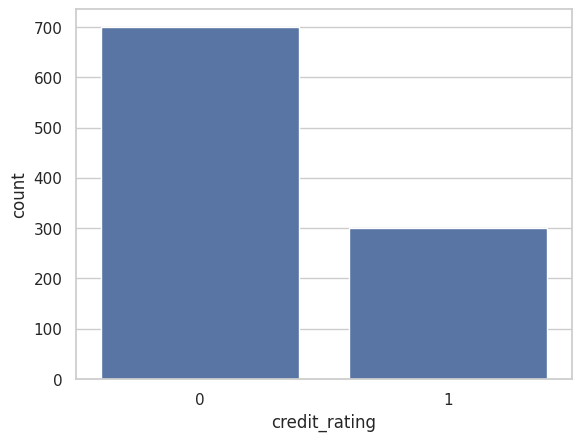

In [ ]:
sns.countplot(x="credit_rating", data = credit_df)

<Axes: xlabel='credit_rating', ylabel='duration'>

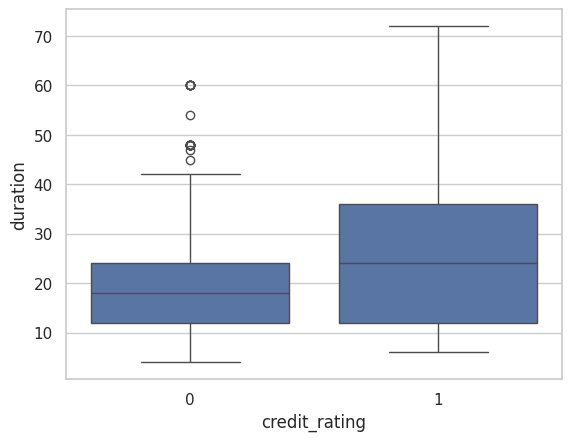

In [ ]:
sns.boxplot(x='credit_rating',y='duration',data=credit_df)

People with a bad credit rating have a higher median duration of credit.

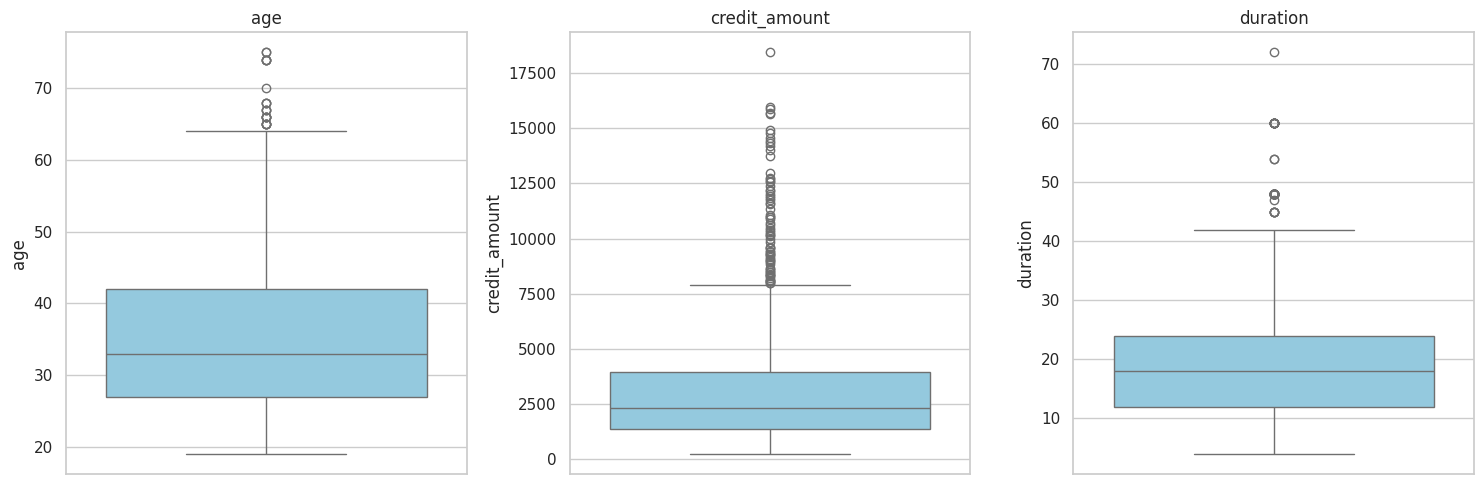

In [ ]:
plt.figure(figsize=(15,5))
for i, col in enumerate(["age","credit_amount","duration"]):
  plt.subplot(1,3,i+1)
  sns.boxplot(y=credit_df[col],color="skyblue")
  plt.title(col)

plt.tight_layout()
plt.show()

age, credit_amount, and duration all have outliers on the upper end of their range of values. This implies that these variables are positively skewed, and that most of their data is concentrated on the lower end of the scale.

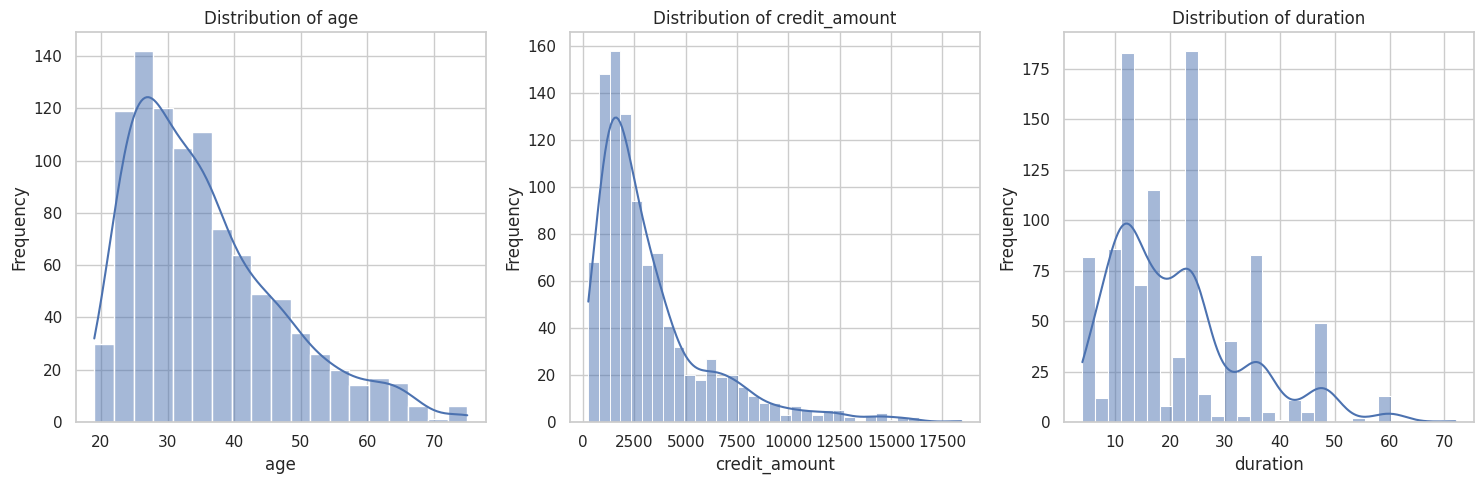

In [18]:
cols = ["age","credit_amount","duration"]
num_cols = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(cols):
    sns.histplot(credit_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These plots show the skewed distribution of these variables. We conduct a log transformation to make these distributions approximately normal.

In [19]:
for col in cols:
  credit_df[f"{col}_log"] = np.log1p(credit_df[col])

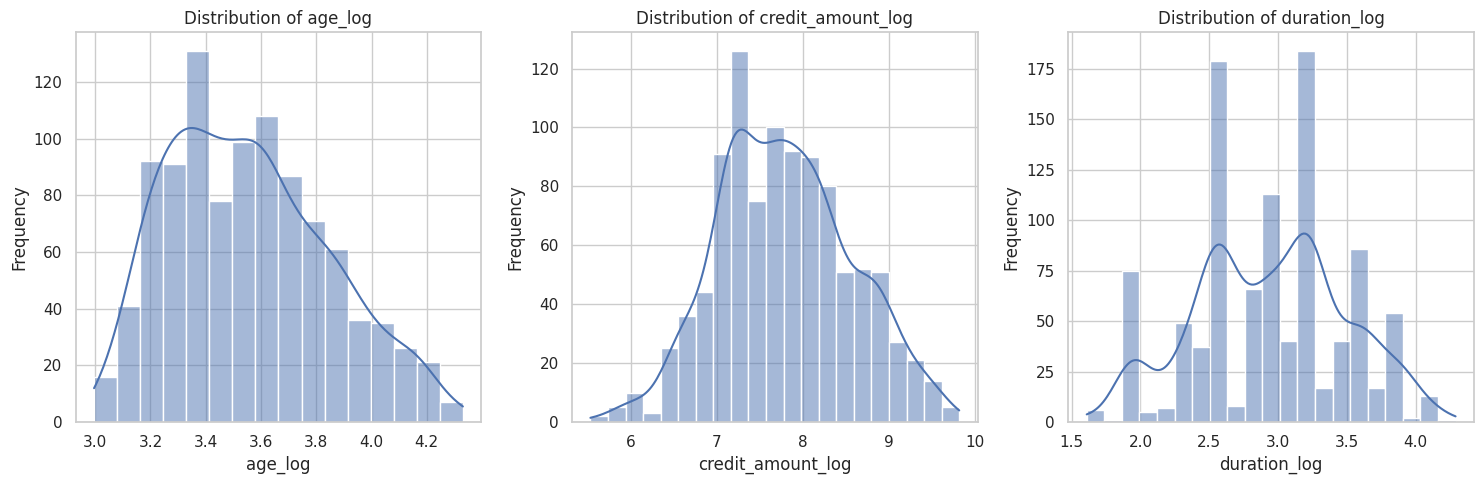

In [20]:
cols = ["age","credit_amount","duration"]
num_cols = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(cols):
    sns.histplot(credit_df[f"{col}_log"], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}_log')
    axes[i].set_xlabel(f"{col}_log")
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account_status  1000 non-null   int64 
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   int64 
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   int64 
 6   employment_status        1000 non-null   int64 
 7   installment_rate         1000 non-null   int64 
 8   other_debtors            1000 non-null   object
 9   present_residence        1000 non-null   int64 
 10  property                 1000 non-null   object
 11  age                      1000 non-null   int64 
 12  other_installment_plans  1000 non-null   object
 13  housing                  1000 non-null   object
 14  num_existing_credits     1000 non-null   

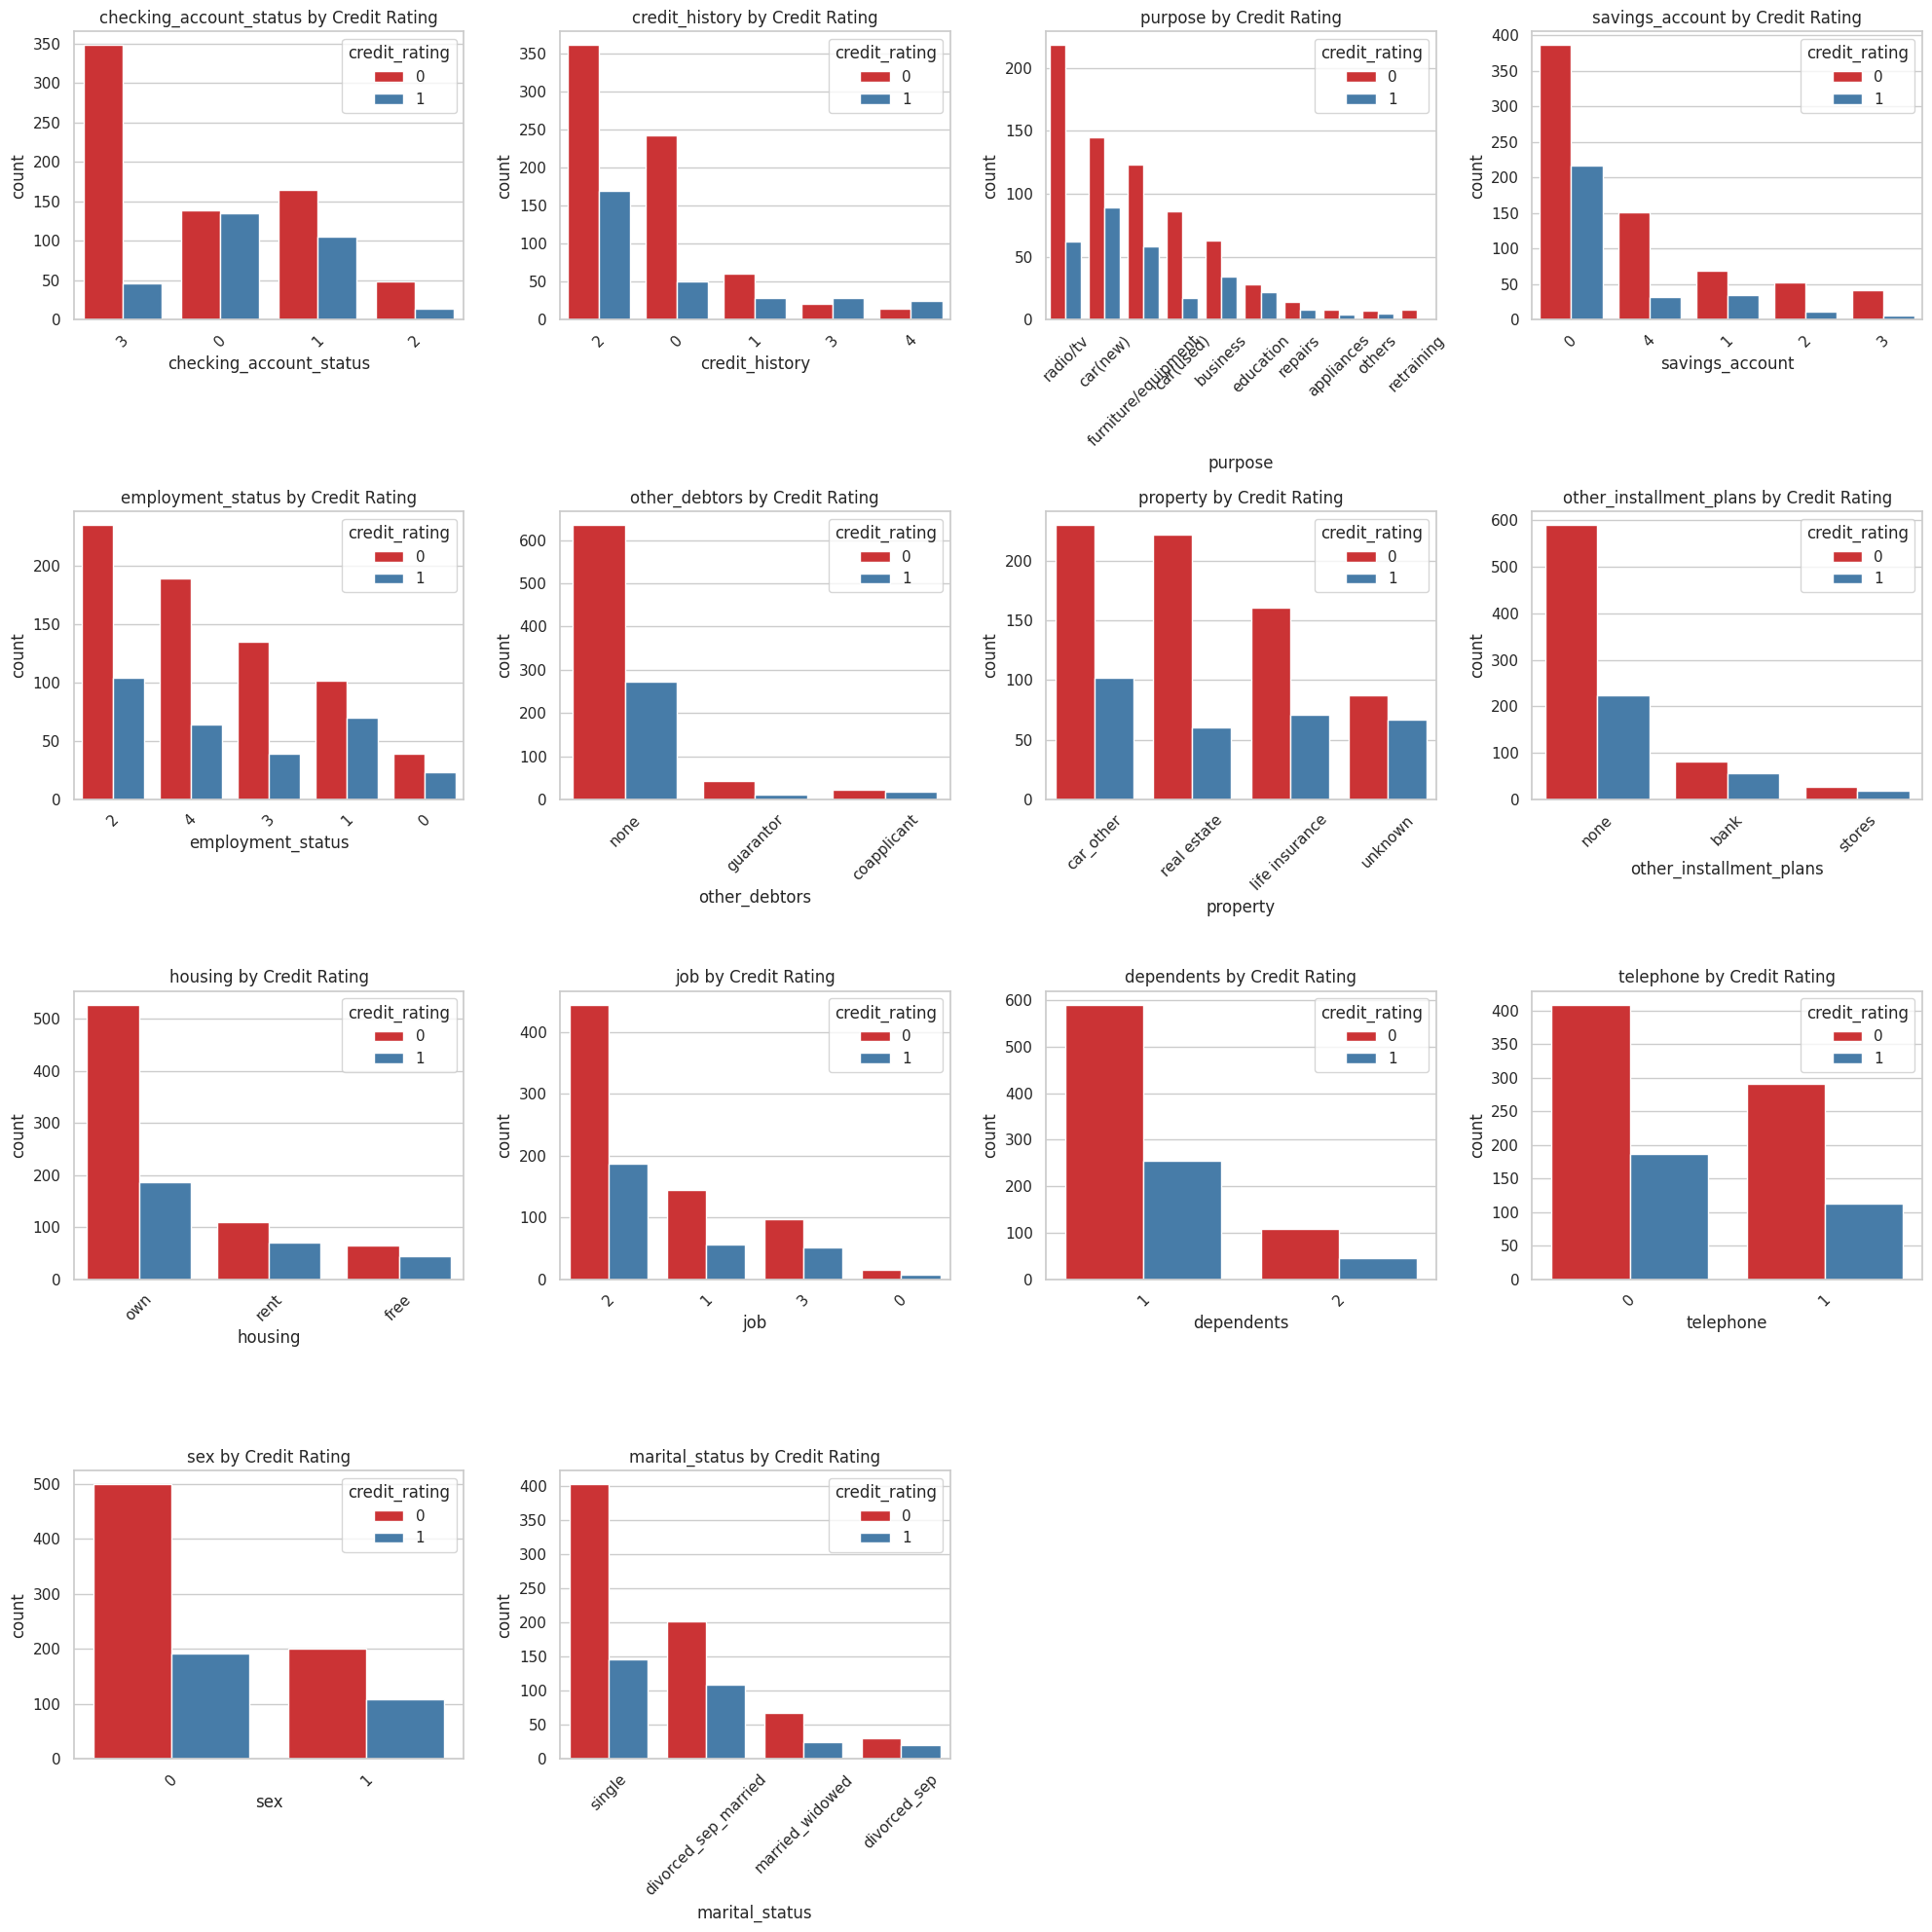

In [ ]:
plt.figure(figsize=(20,20))
object_cols = ["checking_account_status","credit_history","purpose","savings_account",
               "employment_status", "other_debtors","property","other_installment_plans",
               "housing","job","dependents","telephone","sex","marital_status"]

for i, col in enumerate(object_cols):
    plt.subplot(4,4,i+1)
    sns.countplot(data=credit_df, x=col, hue="credit_rating",palette = "Set1",order = credit_df[col].value_counts().index)
    plt.title(f"{col} by Credit Rating")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
credit_df.groupby("job")["credit_amount"].mean()

,credit_amount
job,
0,2745.136364
1,2358.520000
2,3070.965079
3,5435.493243


People with higher seniority have higher credit amounts.

In [ ]:
#sex: male=0, female=1
credit_df.groupby("sex")["credit_amount"].mean()

,credit_amount
sex,
0,3448.040580
1,2877.774194


Men tend to have higher credit amounts than women

In [ ]:
credit_df["purpose"].value_counts()

,count
purpose,
radio/tv,280
car(new),234
furniture/equipment,181
car(used),103
business,97
education,50
repairs,22
appliances,12
others,12


There is no data where purpose of credit is vacation.

In [ ]:
pd.pivot_table(credit_df,values="credit_amount",index="housing",columns = "purpose")

purpose,appliances,business,car(new),car(used),education,furniture/equipment,others,radio/tv,repairs,retraining
housing,,,,,,,,,,
free,NaN,4931.800000,5138.689655,6609.923077,4387.266667,4100.181818,7227.250,2417.333333,2750.666667,NaN
own,1546.5,3800.592105,2811.133333,4915.222222,2492.423077,3107.459016,8700.375,2540.493392,2866.000000,1243.875
rent,1255.5,5614.125000,2597.225000,5037.086957,3156.444444,2727.354167,NaN,2199.763158,1522.000000,902.000


Text(0.5, 1.0, 'Credit amount vs. age colored by sex and sized by duration')

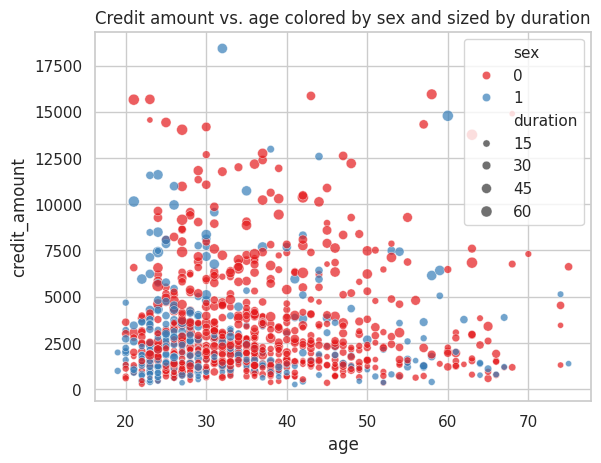

In [22]:
sns.scatterplot(data=credit_df, x="age",y="credit_amount",hue="sex",size="duration",alpha=0.7,palette="Set1")
plt.title("Credit amount vs. age colored by sex and sized by duration")

most of the credits are centered around younger ages and smaller credit amounts.

Text(0.5, 1.0, 'Credit Amount Distribution by Savings Accounts')

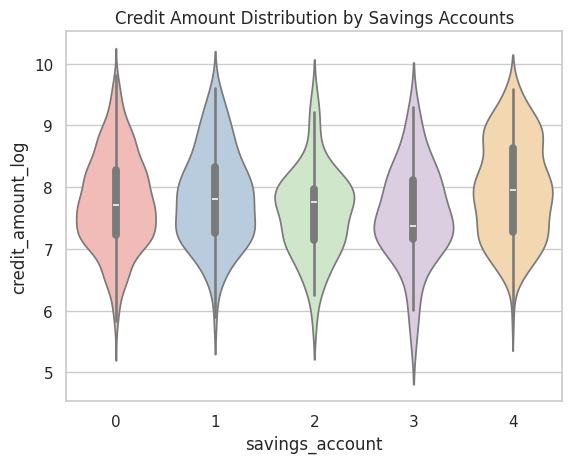

In [23]:
sns.violinplot(data=credit_df,x="savings_account",y="credit_amount_log",palette="Pastel1")
plt.title("Credit Amount Distribution by Savings Accounts")

0-1: savings amount gets higher. 4: unknown

Credit amount is not related to savings accounts.

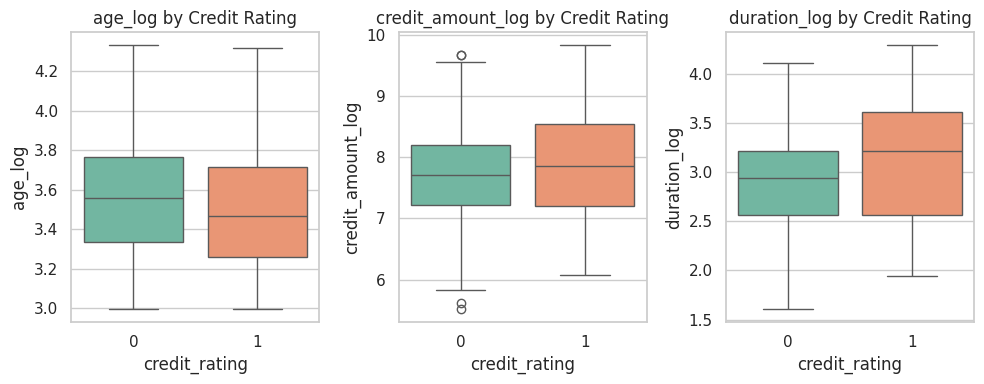

In [24]:
plt.figure(figsize=(10,4))
for i, col in enumerate(["age_log","credit_amount_log","duration_log"]):
  plt.subplot(1,3,i+1)
  sns.boxplot(data=credit_df,x="credit_rating",y=col,palette="Set2")
  plt.title(f"{col} by Credit Rating")

plt.tight_layout()
plt.show()

The transformed numeric variables show a difference in median for good credit rating and bad credit rating.

The people with a bad credit rating tend to have a lower age, higher credit amount, and a longer duration of credit.

Credit rating: `0 : Good`, `1 : Bad`.

In [25]:
credit_df.groupby("credit_rating")[["age_log","credit_amount_log","duration_log"]].mean()

,age_log,credit_amount_log,duration_log
credit_rating,,,
0,3.574107,7.733594,2.863977
1,3.508981,7.919093,3.120525


Higher age, lower credit amount, and shorter duration on average for "good" credit rating.

In [26]:
nominal = ["purpose","other_debtors","property","other_installment_plans",
           "housing","marital_status"]

credit_df = pd.get_dummies(credit_df, columns=nominal,dtype="int")

In [ ]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   checking_account_status              1000 non-null   int64
 1   duration                             1000 non-null   int64
 2   credit_history                       1000 non-null   int64
 3   credit_amount                        1000 non-null   int64
 4   savings_account                      1000 non-null   int64
 5   employment_status                    1000 non-null   int64
 6   installment_rate                     1000 non-null   int64
 7   present_residence                    1000 non-null   int64
 8   age                                  1000 non-null   int64
 9   num_existing_credits                 1000 non-null   int64
 10  job                                  1000 non-null   int64
 11  dependents                           1000 non-null   int6

All categorical variables have been appropriately encoded.

In [27]:
#separate features and target variable
X = credit_df.drop(["credit_rating","age_log","credit_amount_log","duration_log"],axis=1) #with original features
X_log = credit_df.drop(["credit_rating","age","duration","credit_amount"],axis=1) #with log transformed features
y = credit_df["credit_rating"]
y.head()

,credit_rating
0,0
1,1
2,0
3,0
4,1


In [28]:
X.columns

Index(['checking_account_status', 'duration', 'credit_history',
       'credit_amount', 'savings_account', 'employment_status',
       'installment_rate', 'present_residence', 'age', 'num_existing_credits',
       'job', 'dependents', 'telephone', 'foreign_worker', 'sex',
       'purpose_appliances', 'purpose_business', 'purpose_car(new)',
       'purpose_car(used)', 'purpose_education', 'purpose_furniture/equipment',
       'purpose_others', 'purpose_radio/tv', 'purpose_repairs',
       'purpose_retraining', 'other_debtors_coapplicant',
       'other_debtors_guarantor', 'other_debtors_none', 'property_car_other',
       'property_life insurance', 'property_real estate', 'property_unknown',
       'other_installment_plans_bank', 'other_installment_plans_none',
       'other_installment_plans_stores', 'housing_free', 'housing_own',
       'housing_rent', 'marital_status_divorced_sep',
       'marital_status_divorced_sep_married', 'marital_status_married_widowed',
       'marital_status_

In [29]:
X_log.columns

Index(['checking_account_status', 'credit_history', 'savings_account',
       'employment_status', 'installment_rate', 'present_residence',
       'num_existing_credits', 'job', 'dependents', 'telephone',
       'foreign_worker', 'sex', 'age_log', 'credit_amount_log', 'duration_log',
       'purpose_appliances', 'purpose_business', 'purpose_car(new)',
       'purpose_car(used)', 'purpose_education', 'purpose_furniture/equipment',
       'purpose_others', 'purpose_radio/tv', 'purpose_repairs',
       'purpose_retraining', 'other_debtors_coapplicant',
       'other_debtors_guarantor', 'other_debtors_none', 'property_car_other',
       'property_life insurance', 'property_real estate', 'property_unknown',
       'other_installment_plans_bank', 'other_installment_plans_none',
       'other_installment_plans_stores', 'housing_free', 'housing_own',
       'housing_rent', 'marital_status_divorced_sep',
       'marital_status_divorced_sep_married', 'marital_status_married_widowed',
       'mar

## Train-test split

In [30]:
X_train,X_test,X_log_train,X_log_test, y_train, y_test = train_test_split(X, X_log, y, test_size=0.2,stratify=y,random_state = RANDOM_STATE)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_log_train.shape)
print(X_test.shape)
print(X_log_test.shape)
print(y_test.shape)

(800, 42)
(800,)
(800, 42)
(200, 42)
(200, 42)
(200,)


In [32]:
X_train.describe()

,checking_account_status,duration,credit_history,credit_amount,savings_account,employment_status,installment_rate,present_residence,age,num_existing_credits,...,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_free,housing_own,housing_rent,marital_status_divorced_sep,marital_status_divorced_sep_married,marital_status_married_widowed,marital_status_single
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,...,800.000000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,1.580000,20.770000,1.438750,3189.59125,1.111250,2.407500,2.941250,2.83000,35.323750,1.407500,...,0.140000,0.811250,0.04875,0.107500,0.71250,0.180000,0.051250,0.311250,0.100000,0.537500
std,1.258205,11.817325,1.087532,2673.54737,1.572248,1.192989,1.124446,1.11137,11.045313,0.567315,...,0.347204,0.391555,0.21548,0.309942,0.45288,0.384428,0.220645,0.463294,0.300188,0.498904
min,0.000000,4.000000,0.000000,276.00000,0.000000,0.000000,1.000000,1.00000,19.000000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,0.000000,1353.00000,0.000000,2.000000,2.000000,2.00000,27.000000,1.000000,...,0.000000,1.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,18.000000,2.000000,2317.00000,0.000000,2.000000,3.000000,3.00000,33.000000,1.000000,...,0.000000,1.000000,0.00000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,24.000000,2.000000,3933.00000,2.000000,4.000000,4.000000,4.00000,41.000000,2.000000,...,0.000000,1.000000,0.00000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,60.000000,4.000000,15945.00000,4.000000,4.000000,4.000000,4.00000,75.000000,4.000000,...,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
from sklearn.compose import ColumnTransformer

#### For original features

In [ ]:
numeric_features = ["duration","credit_amount","installment_rate",
                    "present_residence","age","num_existing_credits",
                    "dependents"]

In [38]:
# Define the numeric features to scale
scaled_features = ['age', 'credit_amount', 'duration']

# Create the ColumnTransformer
scaler_ct = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scaled_features)
    ],
    remainder='passthrough'   # leave all other columns unchanged
)

# Apply the preprocessor to the training and test data
X_train_scaled = scaler_ct.fit_transform(X_train)
X_test_scaled = scaler_ct.transform(X_test)


new_feature_names = (
    scaled_features +    # scaled columns (centered & standardized)
    [col for col in X_train.columns if col not in scaled_features]  # untouched columns
)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=new_feature_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=new_feature_names, index=X_test.index)

X_train_scaled.describe()

,age,credit_amount,duration,checking_account_status,credit_history,savings_account,employment_status,installment_rate,present_residence,num_existing_credits,...,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_free,housing_own,housing_rent,marital_status_divorced_sep,marital_status_divorced_sep_married,marital_status_married_widowed,marital_status_single
count,8.000000e+02,8.000000e+02,8.000000e+02,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,...,800.000000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,3.153033e-16,3.608225e-17,6.217249e-17,1.580000,1.438750,1.111250,2.407500,2.941250,2.83000,1.407500,...,0.140000,0.811250,0.04875,0.107500,0.71250,0.180000,0.051250,0.311250,0.100000,0.537500
std,1.000626e+00,1.000626e+00,1.000626e+00,1.258205,1.087532,1.572248,1.192989,1.124446,1.11137,0.567315,...,0.347204,0.391555,0.21548,0.309942,0.45288,0.384428,0.220645,0.463294,0.300188,0.498904
min,-1.478814e+00,-1.090467e+00,-1.419991e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.540716e-01,-6.873790e-01,-7.425950e-01,0.000000,0.000000,0.000000,2.000000,2.000000,2.00000,1.000000,...,0.000000,1.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.105150e-01,-3.265838e-01,-2.345483e-01,1.000000,2.000000,0.000000,2.000000,3.000000,3.00000,1.000000,...,0.000000,1.000000,0.00000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.142273e-01,2.782348e-01,2.734985e-01,3.000000,2.000000,2.000000,4.000000,4.000000,4.00000,2.000000,...,0.000000,1.000000,0.00000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,1.000000
max,3.594382e+00,4.773953e+00,3.321779e+00,3.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,...,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
X_train_scaled.head()

,age,credit_amount,duration,checking_account_status,credit_history,savings_account,employment_status,installment_rate,present_residence,num_existing_credits,...,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_free,housing_own,housing_rent,marital_status_divorced_sep,marital_status_divorced_sep_married,marital_status_married_widowed,marital_status_single
828,1.057784,1.925766,1.289592,0.0,2.0,4.0,4.0,3.0,4.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
997,0.242449,-0.892853,-0.742595,3.0,2.0,0.0,4.0,4.0,4.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
148,-0.663479,0.816433,1.289592,0.0,0.0,0.0,2.0,3.0,2.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
735,-0.572886,0.299568,1.289592,1.0,3.0,4.0,1.0,3.0,2.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
130,-1.025850,1.982655,2.305686,1.0,2.0,4.0,3.0,1.0,2.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### For log transformed features

In [35]:
# Define the numeric features to scale
scaled_features = ['age_log', 'credit_amount_log', 'duration_log']

# Create the ColumnTransformer
scaler_ct = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scaled_features)
    ],
    remainder='passthrough'   # leave all other columns unchanged
)

# Apply the preprocessor to the training and test data
X_log_train_scaled = scaler_ct.fit_transform(X_log_train)
X_log_test_scaled = scaler_ct.transform(X_log_test)


new_feature_names = (
    scaled_features +    # scaled columns (centered & standardized)
    [col for col in X_log_train.columns if col not in scaled_features]  # untouched columns
)

X_log_train_scaled = pd.DataFrame(X_log_train_scaled, columns=new_feature_names, index=X_log_train.index)
X_log_test_scaled = pd.DataFrame(X_log_test_scaled, columns=new_feature_names, index=X_log_test.index)

X_log_train_scaled.describe()

,age_log,credit_amount_log,duration_log,checking_account_status,credit_history,savings_account,employment_status,installment_rate,present_residence,num_existing_credits,...,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_free,housing_own,housing_rent,marital_status_divorced_sep,marital_status_divorced_sep_married,marital_status_married_widowed,marital_status_single
count,8.000000e+02,8.000000e+02,8.000000e+02,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,...,800.000000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,9.503509e-16,9.880985e-17,-4.396483e-16,1.580000,1.438750,1.111250,2.407500,2.941250,2.83000,1.407500,...,0.140000,0.811250,0.04875,0.107500,0.71250,0.180000,0.051250,0.311250,0.100000,0.537500
std,1.000626e+00,1.000626e+00,1.000626e+00,1.258205,1.087532,1.572248,1.192989,1.124446,1.11137,0.567315,...,0.347204,0.391555,0.21548,0.309942,0.45288,0.384428,0.220645,0.463294,0.300188,0.498904
min,-1.951434e+00,-2.789742e+00,-2.453336e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.679568e-01,-7.286325e-01,-6.884914e-01,0.000000,0.000000,0.000000,2.000000,2.000000,2.00000,1.000000,...,0.000000,1.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.504977e-02,-3.028004e-02,1.243166e-02,1.000000,2.000000,0.000000,2.000000,3.000000,3.00000,1.000000,...,0.000000,1.000000,0.00000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.581899e-01,6.567816e-01,5.193207e-01,3.000000,2.000000,2.000000,4.000000,4.000000,4.00000,2.000000,...,0.000000,1.000000,0.00000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2.744179e+00,2.474675e+00,2.166855e+00,3.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,...,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


## Fitting Baseline models
Baseline models:
* Logistic Regression
* K-Neighbors Classifier
* Decision Tree Classifier
* Random Forest Classifier
* XGB Classifier

In [36]:
def eval_model(models, X, y, cv):
    """
    Evaluate a dict or list of (name, estimator) using stratified CV.
    Returns a DataFrame where each row is a model and columns are mean metrics across folds.
    """
    # Normalize models input
    if isinstance(models, dict):
        model_items = list(models.items())
    else:
        model_items = list(models)  # expect list of (name, estimator)

    results = []
    for name, estimator in model_items:
        accs = []; precs = []; recs = []; f1s = []; specs = []; rocs = []

        for train_idx, test_idx in cv.split(X, y):
            # support both pandas and numpy arrays
            X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
            X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
            y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
            y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)

            # ROC AUC: handle estimators without predict_proba gracefully
            if hasattr(estimator, "predict_proba"):
                try:
                    y_proba = estimator.predict_proba(X_test)[:, 1]
                    roc = roc_auc_score(y_test, y_proba)
                except Exception:
                    roc = np.nan
            elif hasattr(estimator, "decision_function"):
                try:
                    scores = estimator.decision_function(X_test)
                    roc = roc_auc_score(y_test, scores)
                except Exception:
                    roc = np.nan
            else:
                roc = np.nan

            # metrics (zero_division protects precision/recall when no positive preds)
            accs.append(accuracy_score(y_test, y_pred))
            precs.append(precision_score(y_test, y_pred, zero_division=0))
            recs.append(recall_score(y_test, y_pred, zero_division=0))
            f1s.append(f1_score(y_test, y_pred, zero_division=0))

            # specificity = tn / (tn + fp), handle edge cases
            cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
            if cm.size == 4:
                tn, fp, fn, tp = cm.ravel()
                spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0
            else:
                spec = 0.0
            specs.append(spec)
            rocs.append(roc)

        results.append({
            'model': name,
            'roc_auc': np.nanmean(rocs) if not all(np.isnan(rocs)) else np.nan,
            'recall': np.mean(recs),
            'specificity': np.mean(specs),
            'precision': np.mean(precs),
            'f1': np.mean(f1s),
            'accuracy': np.mean(accs)
          })

    base_results_df = pd.DataFrame(results).set_index('model')

    # sort by roc_auc if available
    if 'roc_auc' in base_results_df.columns:
        base_results_dfdf = base_results_df.sort_values('roc_auc', ascending=False)
    return base_results_df



### Original features

In [40]:
#baseline models
# Define baseline classifiers
models = {
    'Logistic': LogisticRegression(max_iter=5000, class_weight='balanced', random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'RF': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced'),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

base_metrics = eval_model(models, X_train_scaled,y_train,cv)
base_metrics

,roc_auc,recall,specificity,precision,f1,accuracy
model,,,,,,
Logistic,0.780469,0.708333,0.725000,0.524875,0.602342,0.72000
KNN,0.719624,0.391667,0.903571,0.630827,0.482149,0.75000
Tree,0.611012,0.466667,0.755357,0.449152,0.457292,0.66875
RF,0.790086,0.320833,0.932143,0.658981,0.430016,0.74875
XGB,0.776935,0.504167,0.857143,0.603719,0.547949,0.75125


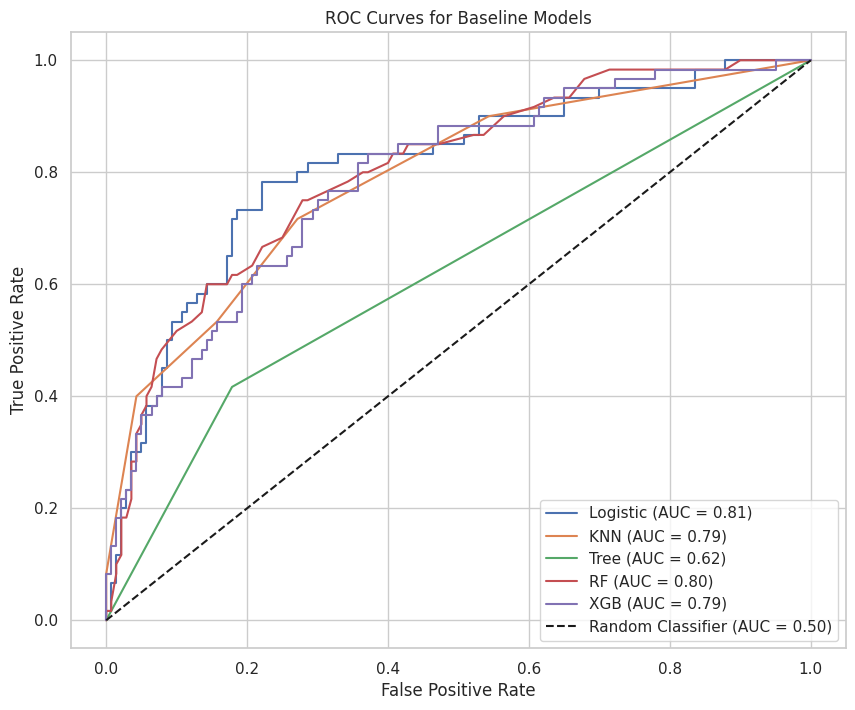

In [41]:
plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Baseline Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [42]:
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Good (0)', 'Predicted Bad (1)'],
                yticklabels=['Actual Good (0)', 'Actual Bad (1)'])
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

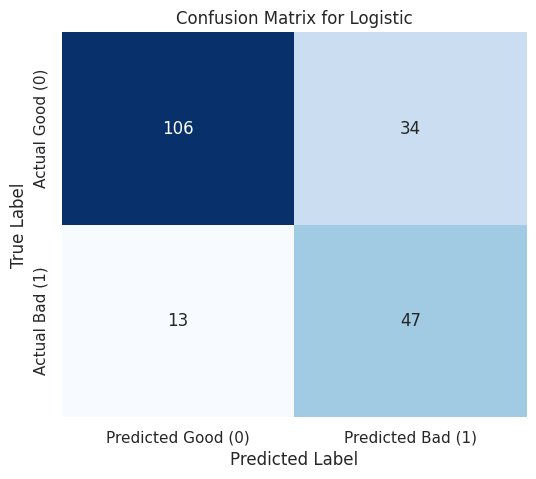

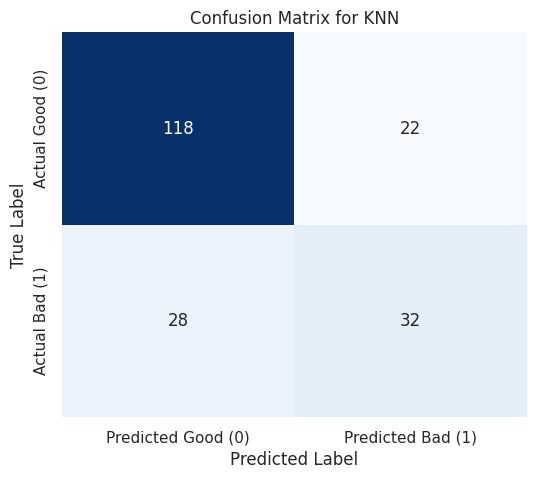

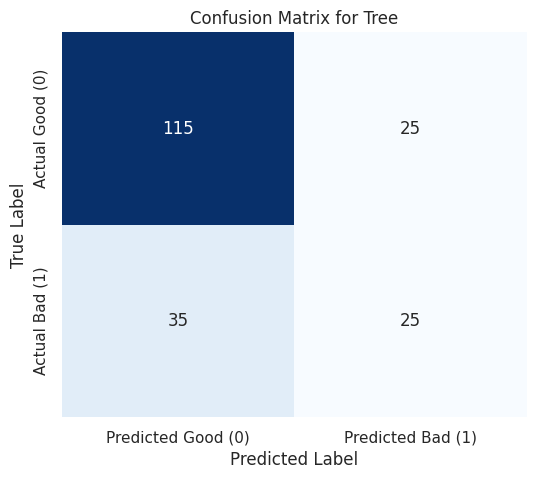

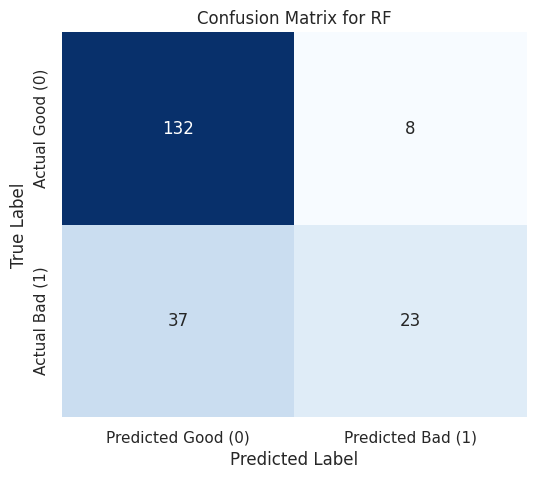

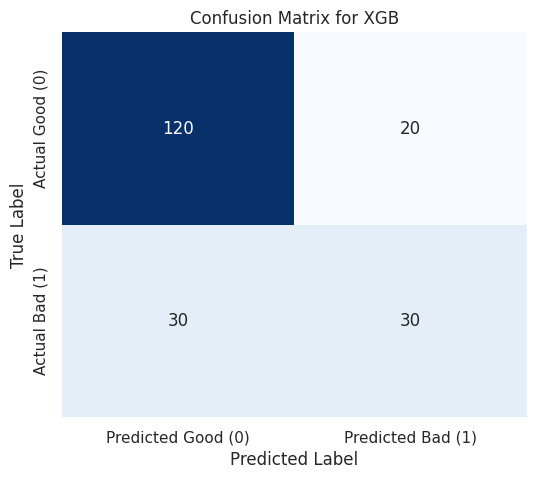

In [43]:
# Plot and interpret confusion matrices for each model
for name, model in models.items():
    plot_confusion_matrix(model, X_test_scaled, y_test, name)

    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()


### Hyperparameter tuning


In [44]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=RANDOM_STATE)
scoring = "roc_auc"
n_jobs=-1

#### Logistic Regression

In [45]:
log_hp = LogisticRegression(solver='saga',max_iter=5000,random_state=RANDOM_STATE)

log_param = {
    'C': [1e-4,1e-3,1e-2,1e-1,1,10,100],
    'penalty': ["l1","l2","elasticnet"],
    'l1_ratio': [0.0,0.25,0.5,0.75,1.0] # for elasticnet
}

log_search = RandomizedSearchCV(
    log_hp,
    param_distributions=log_param,
    n_iter=40,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs = n_jobs,
    refit=True
)

log_search.fit(X_train_scaled,y_train)
print("Logistic best ROC-AUC:",log_search.best_score_)
print("Logistic best params: ",log_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic best ROC-AUC: 0.7890997023809524
Logistic best params:  {'penalty': 'elasticnet', 'l1_ratio': 0.0, 'C': 0.1}


#### K-Nearest Neighbors

In [46]:
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 30, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_scaled, y_train)
    train_score[neighbor]=knn.score(X_train_scaled, y_train)
    test_score[neighbor]=knn.score(X_test_scaled, y_test)

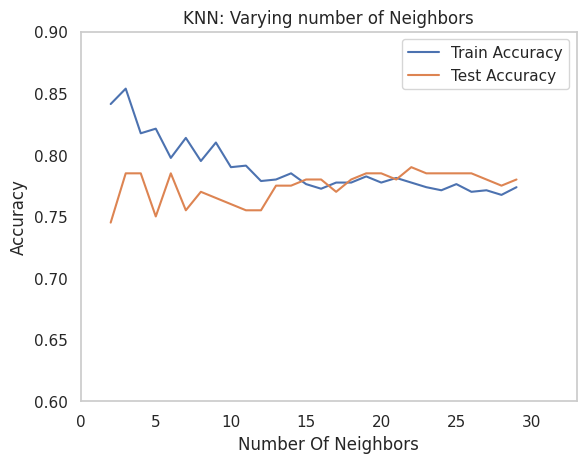

In [47]:
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 33)
plt.ylim(0.60, 0.90)
plt.grid()
plt.show()

In [48]:
for key, value in test_score.items():
    if value==max(test_score.values()):
        print(key)

22


We get the highest accuracy for k=22 neighbors

#### Decision Tree

In [49]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")

dt_params = {
    'criterion':["gini","entropy","log_loss"],
    'max_depth':[None, 3,5,8,10,15,20],
    'min_samples_split':[2,5,10,20],
    'min_samples_leaf': [1,2,4,8],
    'max_features':[None,'sqrt','log2',0.2,0.5]
}

dt_search = RandomizedSearchCV(
    dt,
    param_distributions=dt_params,
    n_iter=40,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=n_jobs,
    refit=True
)

dt_search.fit(X_train_scaled,y_train)
print("Decision Tree best roc_auc (randomized):", dt_search.best_score_)
print("Decision Tree best params (randomized):", dt_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Decision Tree best roc_auc (randomized): 0.7214657738095238
Decision Tree best params (randomized): {'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 0.5, 'max_depth': 5, 'criterion': 'gini'}


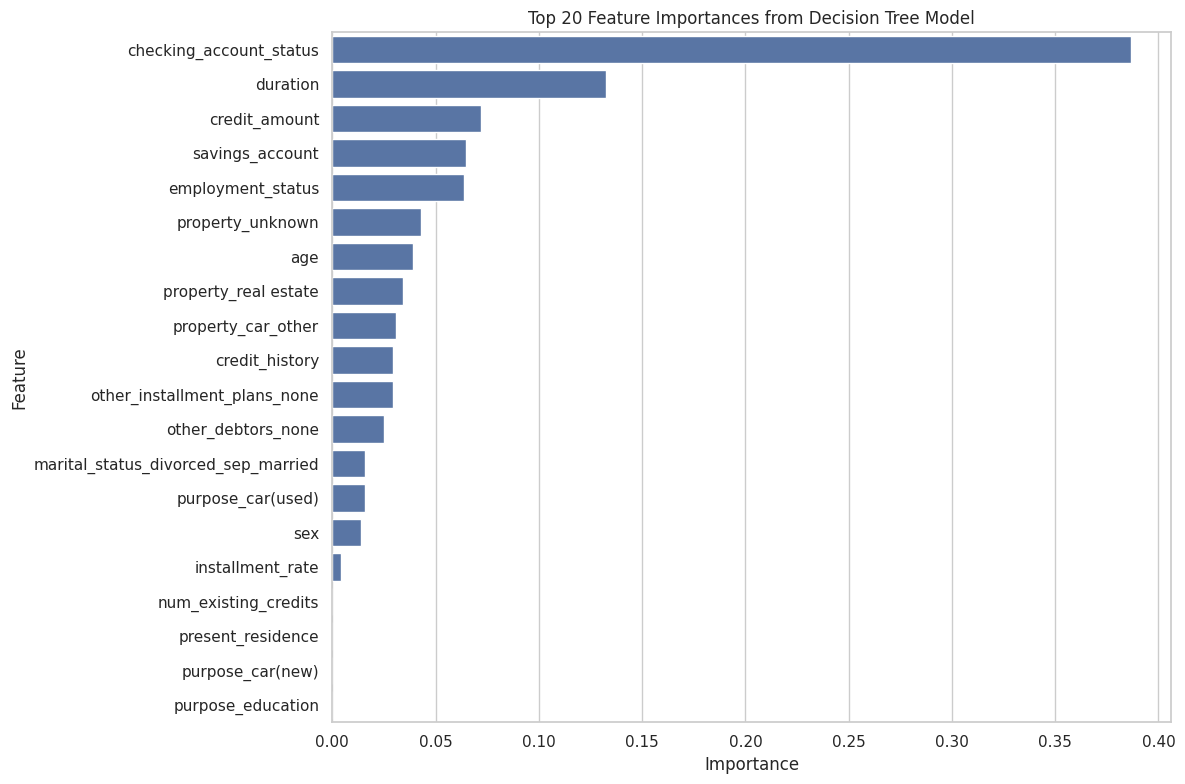

In [50]:
# Get the best Decision Tree model
best_dt_model = dt_search.best_estimator_

# Get feature importances
feature_importances_dt = best_dt_model.feature_importances_

# Get feature names
feature_names_dt = X_train_scaled.columns

# Create a DataFrame for better visualization
importance_df_dt = pd.DataFrame({
    'Feature': feature_names_dt,
    'Importance': feature_importances_dt
})

# Sort by importance
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_dt.head(20))
plt.title('Top 20 Feature Importances from Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Random Forest

In [51]:
# Random Forest: Randomized search
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1)

rf_param_dist = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [5, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.2, 0.5],
    'class_weight': [None, 'balanced']
}

rf_search = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_dist,
    n_iter=40,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=n_jobs,
    refit=True
)
rf_search.fit(X_train_scaled, y_train)
print("RF best roc_auc:", rf_search.best_score_)
print("RF best params:", rf_search.best_params_)

#Grid refine (narrow around best values)
best = rf_search.best_params_
rf_grid = {
    'n_estimators': [best['n_estimators'], best['n_estimators'] + 200] if best['n_estimators'] < 800 else [best['n_estimators']],
    'max_depth': [best['max_depth']],
    'min_samples_leaf': [max(1, best['min_samples_leaf'] - 1), best['min_samples_leaf'], best['min_samples_leaf'] + 1]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                              param_grid=rf_grid, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)
rf_grid_search.fit(X_train_scaled, y_train)
print("RF grid best:", rf_grid_search.best_score_, rf_grid_search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
RF best roc_auc: 0.8009672619047619
RF best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
RF grid best: 0.798251488095238 {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 400}


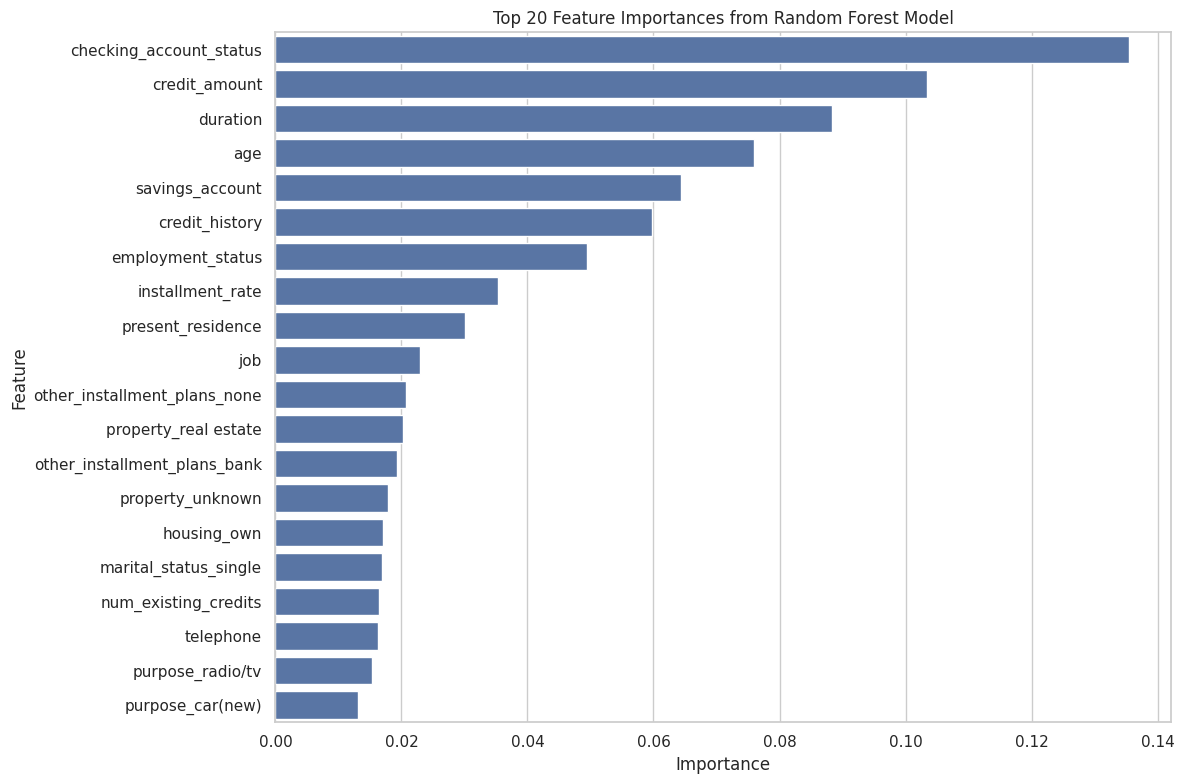

In [52]:
best_rf_model = rf_search.best_estimator_

# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Get feature names (from X_train_scaled columns)
feature_names = X_train_scaled.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### XGBoost

In [53]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss",random_state=RANDOM_STATE)

xgb_params = {
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'scale_pos_weight': [1, (np.sum(y_train==0) / np.sum(y_train==1))]  # try default 1 and imbalance ratio
}

xgb_search = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_params,
    n_iter=50,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=n_jobs,
    refit=True
)
xgb_search.fit(X_train_scaled, y_train)
print("XGB best roc_auc:", xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGB best roc_auc: 0.80859375
XGB best params: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}


### Feature Importances for XGBoost Model

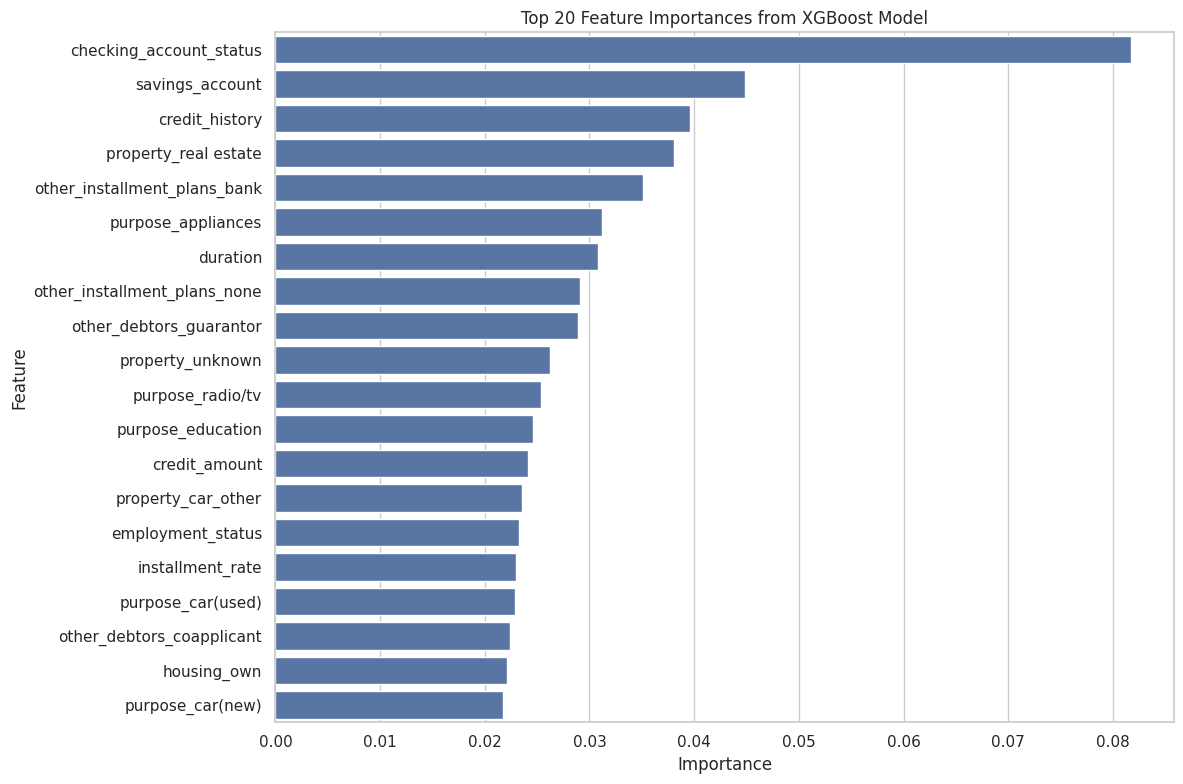

In [54]:
# Get the best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Get feature importances
feature_importances_xgb = best_xgb_model.feature_importances_

# Get feature names
feature_names_xgb = X_train_scaled.columns

# Create a DataFrame for better visualization
importance_df_xgb = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': feature_importances_xgb
})

# Sort by importance
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb.head(20))
plt.title('Top 20 Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [56]:
# Retrieve the best KNN model based on the optimal number of neighbors found
best_knn_model = KNeighborsClassifier(n_neighbors=22)

# Collect all best estimators
best_models = {
    'Logistic Regression': log_search.best_estimator_,
    'K-Nearest Neighbors': best_knn_model,
    'Decision Tree': dt_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_
}


def evaluate_on_test_set(models_dict, X_test, y_test):
    """
    Evaluates a dictionary of trained models on a given test set.
    Returns a DataFrame with various metrics for each model.
    """
    results = []
    for name, model in models_dict.items():
        if name == 'K-Nearest Neighbors':
            model.fit(X_train_scaled, y_train) # Fit KNN to training data before predicting on test

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Specificity
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0
        else:
            spec = 0.0

        # ROC AUC
        roc = np.nan
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
                roc = roc_auc_score(y_test, y_proba)
            except Exception:
                pass
        elif hasattr(model, "decision_function"):
            try:
                scores = model.decision_function(X_test)
                roc = roc_auc_score(y_test, scores)
            except Exception:
                pass

        results.append({
            'model': name,
            'roc_auc': roc,
            'recall': rec,
            'accuracy': acc,
            'precision': prec,
            'f1': f1,
            'specificity': spec,
        })

    return pd.DataFrame(results).set_index('model').sort_values('roc_auc', ascending=False)

# Evaluate all best models on the final test set
test_metrics = evaluate_on_test_set(best_models, X_test_scaled, y_test)
print("Evaluation Metrics of Best Models on Test Set:")
display(test_metrics)

Evaluation Metrics of Best Models on Test Set:


,roc_auc,recall,accuracy,precision,f1,specificity
model,,,,,,
Logistic Regression,0.812857,0.516667,0.780,0.673913,0.584906,0.892857
Random Forest,0.805000,0.566667,0.755,0.596491,0.581197,0.835714
XGBoost,0.798333,0.466667,0.770,0.666667,0.549020,0.900000
K-Nearest Neighbors,0.793155,0.450000,0.790,0.750000,0.562500,0.935714
Decision Tree,0.757738,0.683333,0.700,0.500000,0.577465,0.707143


In [57]:
best_knn_model = KNeighborsClassifier(n_neighbors=22)
best_knn_model.fit(X_train_scaled,y_train)

best_models = {
    'Logistic Regression': log_search.best_estimator_,
    'K-Nearest Neighbors': best_knn_model,
    'Decision Tree': dt_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_
}

print("Best models retrieved successfully:")
for name, model in best_models.items():
    print(f"- {name}: {model}")

Best models retrieved successfully:
- Logistic Regression: LogisticRegression(C=0.1, l1_ratio=0.0, max_iter=5000, penalty='elasticnet',
                   random_state=42, solver='saga')
- K-Nearest Neighbors: KNeighborsClassifier(n_neighbors=22)
- Decision Tree: DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_features=0.5,
                       min_samples_leaf=8, min_samples_split=20,
                       random_state=42)
- Random Forest: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_leaf=2,
                       n_estimators=400, n_jobs=1, random_state=42)
- XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
 

## Plot Confusion Matrices for Best Models


--- Confusion Matrix for Logistic Regression ---


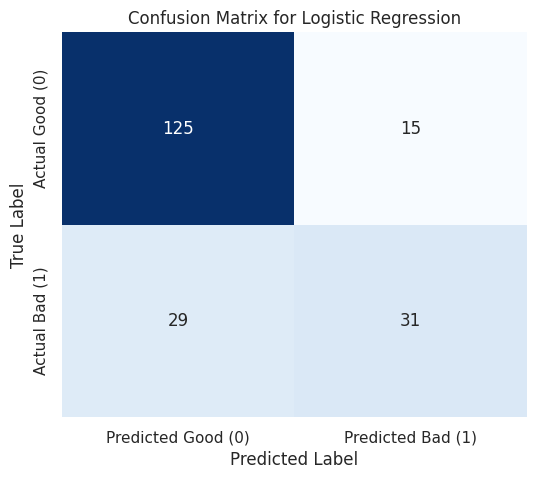


--- Confusion Matrix for K-Nearest Neighbors ---


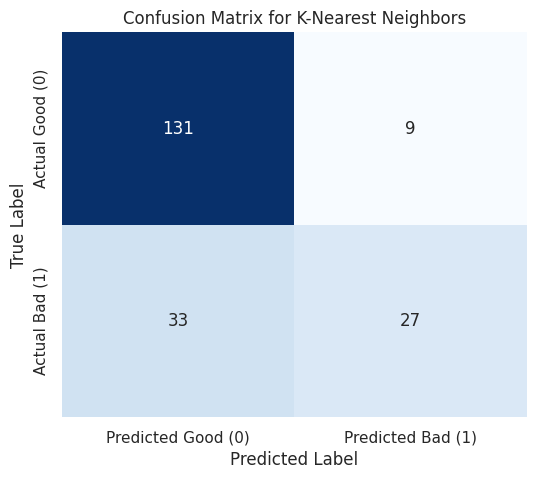


--- Confusion Matrix for Decision Tree ---


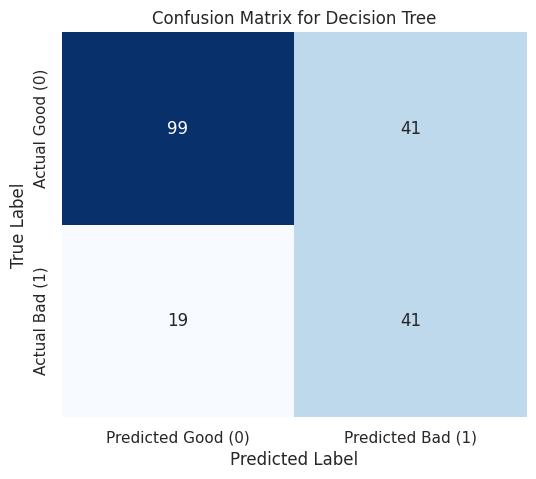


--- Confusion Matrix for Random Forest ---


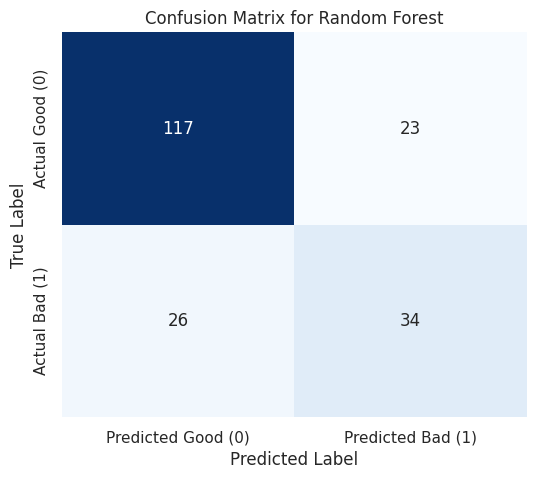


--- Confusion Matrix for XGBoost ---


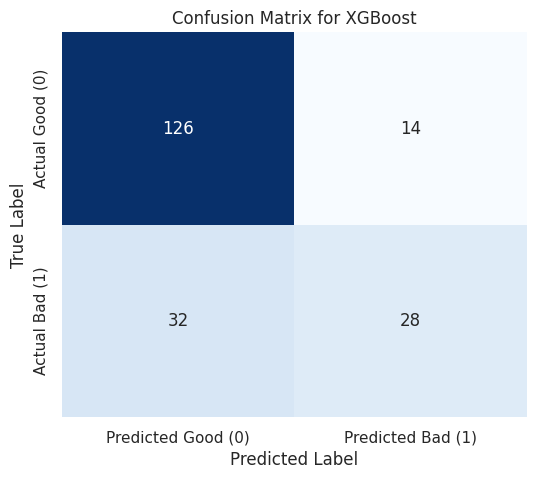

In [ ]:
# The plot_confusion_matrix function has already been defined.
# Iterate through the best models and plot their confusion matrices.
for name, model in best_models.items():
    print(f"\n--- Confusion Matrix for {name} ---")
    plot_confusion_matrix(model, X_test_scaled, y_test, name)


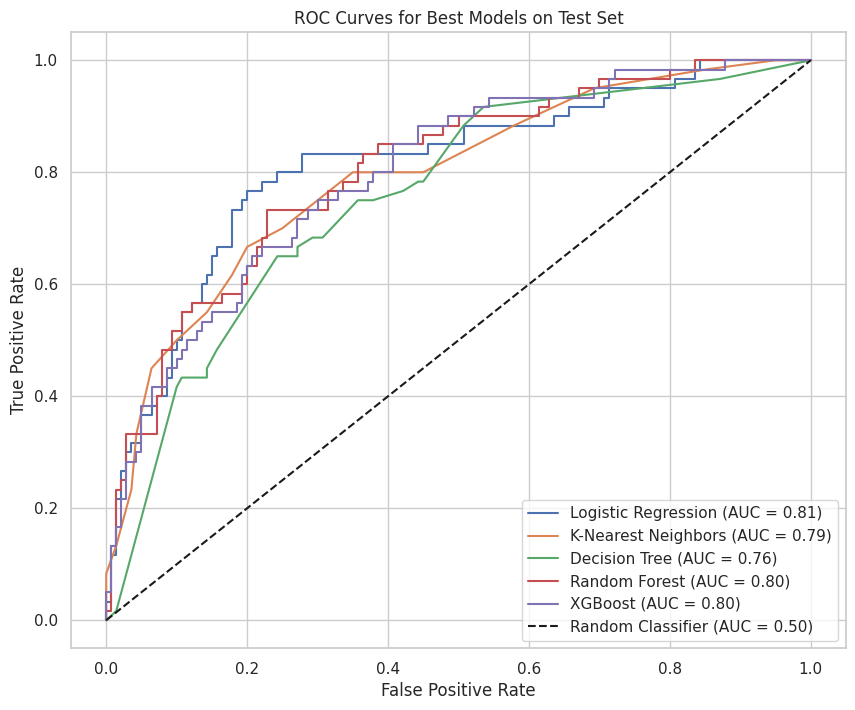

In [ ]:
plt.figure(figsize=(10, 8))

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_scaled)
    else:
        print(f"Warning: Model {name} does not have predict_proba or decision_function. Skipping ROC curve.")
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Best Models on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### For log-transformed features

In [59]:
#baseline models
# Define baseline classifiers
models = {
    'Logistic': LogisticRegression(max_iter=5000, class_weight='balanced', random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'RF': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced'),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

base_metrics = eval_model(models, X_log_train_scaled,y_train,cv)
base_metrics

,roc_auc,recall,specificity,precision,f1,accuracy
model,,,,,,
Logistic,0.782664,0.679167,0.732143,0.521386,0.588969,0.71625
KNN,0.736347,0.420833,0.892857,0.618144,0.498420,0.75125
Tree,0.615179,0.475000,0.755357,0.453381,0.463443,0.67125
RF,0.789658,0.325000,0.932143,0.662314,0.434705,0.75000
XGB,0.776935,0.504167,0.857143,0.603719,0.547949,0.75125


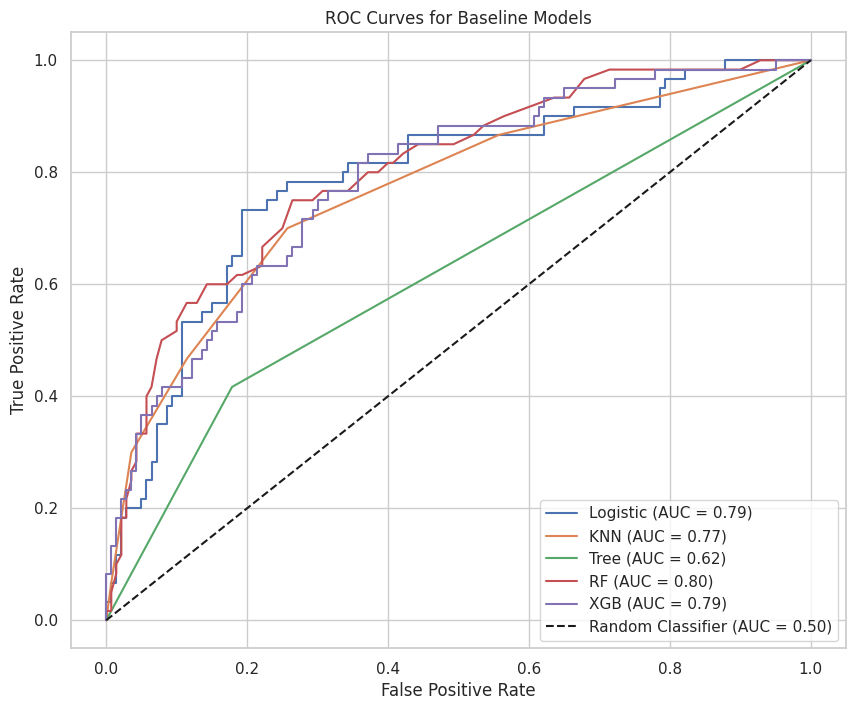

In [60]:
plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_log_train_scaled, y_train)
    y_proba = model.predict_proba(X_log_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Baseline Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Good (0)', 'Predicted Bad (1)'],
                yticklabels=['Actual Good (0)', 'Actual Bad (1)'])
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

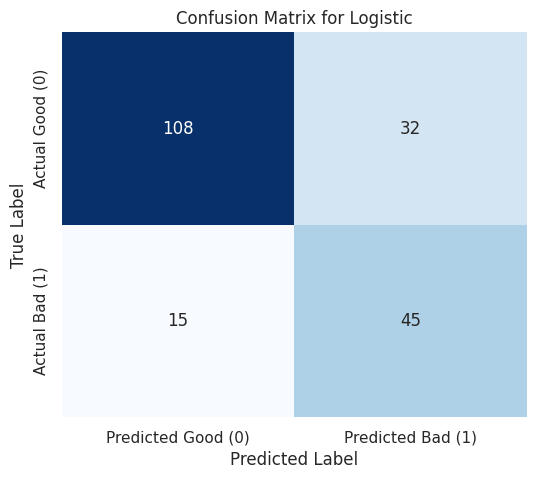

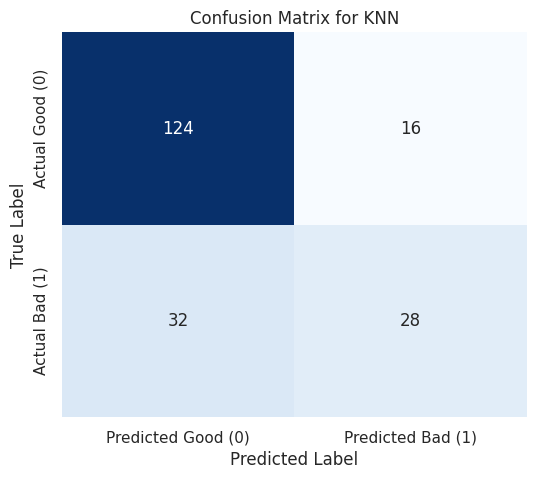

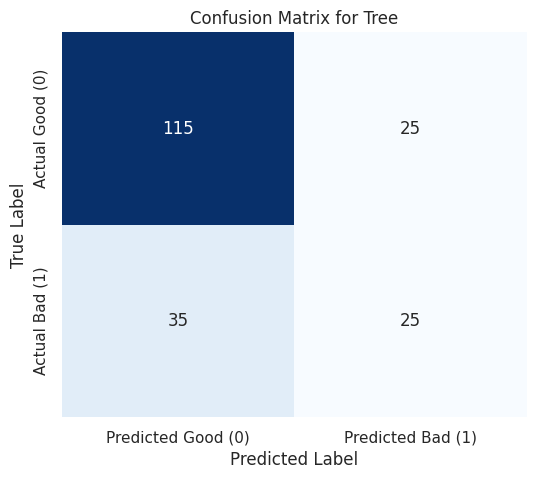

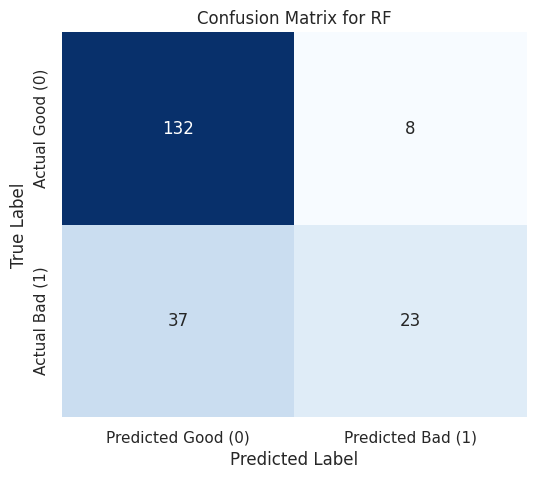

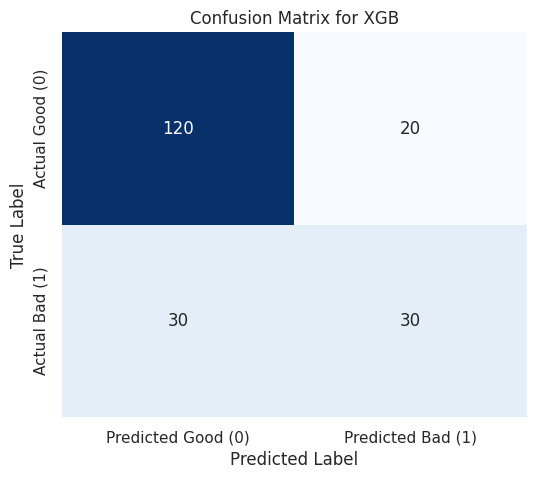

In [61]:
# Plot and interpret confusion matrices for each model
for name, model in models.items():
    plot_confusion_matrix(model, X_log_test_scaled, y_test, name)

    y_pred = model.predict(X_log_test_scaled)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()


### Hyperparameter tuning


In [62]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=RANDOM_STATE)
scoring = "roc_auc"
n_jobs=-1

#### Logistic Regression

In [63]:
log_hp = LogisticRegression(solver='saga',max_iter=5000,random_state=RANDOM_STATE)

log_param = {
    'C': [1e-4,1e-3,1e-2,1e-1,1,10,100],
    'penalty': ["l1","l2","elasticnet"],
    'l1_ratio': [0.0,0.25,0.5,0.75,1.0] # for elasticnet
}

log_search = RandomizedSearchCV(
    log_hp,
    param_distributions=log_param,
    n_iter=40,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs = n_jobs,
    refit=True
)

log_search.fit(X_log_train_scaled,y_train)
print("Logistic best ROC-AUC:",log_search.best_score_)
print("Logistic best params: ",log_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic best ROC-AUC: 0.7896577380952381
Logistic best params:  {'penalty': 'elasticnet', 'l1_ratio': 0.0, 'C': 0.1}


#### K-Nearest Neighbors

In [64]:
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 30, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_log_train_scaled, y_train)
    train_score[neighbor]=knn.score(X_log_train_scaled, y_train)
    test_score[neighbor]=knn.score(X_log_test_scaled, y_test)

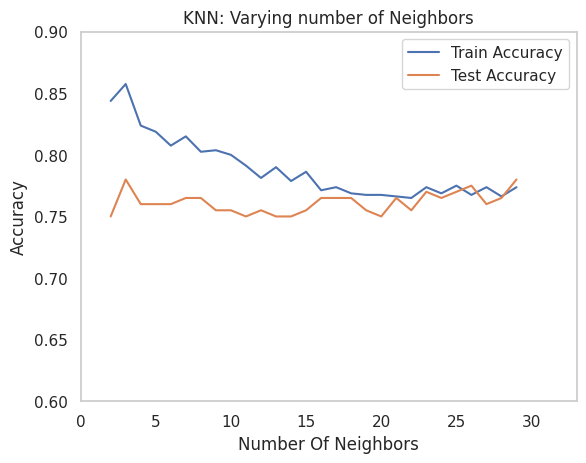

In [65]:
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 33)
plt.ylim(0.60, 0.90)
plt.grid()
plt.show()

In [66]:
for key, value in test_score.items():
    if value==max(test_score.values()):
        print(key)

3
29


We get the highest accuracy for k=3,29 neighbors

#### Decision Tree

In [67]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")

dt_params = {
    'criterion':["gini","entropy","log_loss"],
    'max_depth':[None, 3,5,8,10,15,20],
    'min_samples_split':[2,5,10,20],
    'min_samples_leaf': [1,2,4,8],
    'max_features':[None,'sqrt','log2',0.2,0.5]
}

dt_search = RandomizedSearchCV(
    dt,
    param_distributions=dt_params,
    n_iter=40,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=n_jobs,
    refit=True
)

dt_search.fit(X_log_train_scaled,y_train)
print("Decision Tree best roc_auc (randomized):", dt_search.best_score_)
print("Decision Tree best params (randomized):", dt_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Decision Tree best roc_auc (randomized): 0.7214657738095238
Decision Tree best params (randomized): {'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 0.5, 'max_depth': 5, 'criterion': 'gini'}


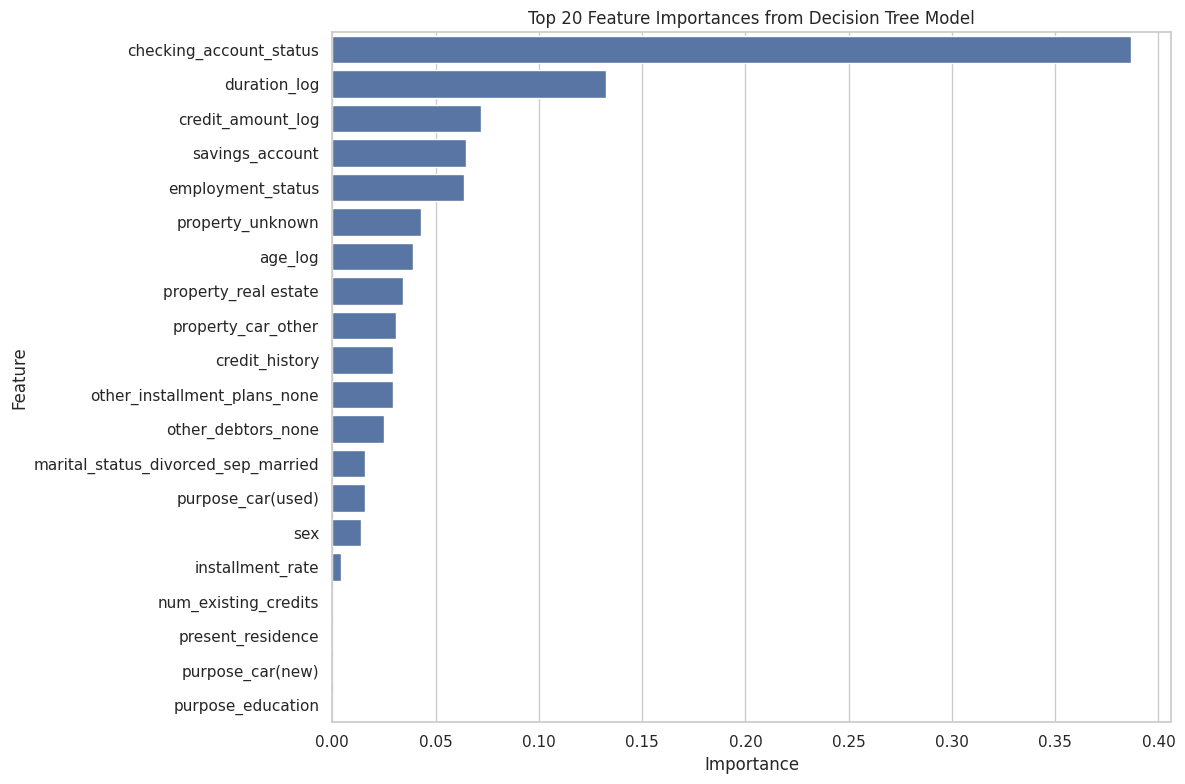

In [68]:
# Get the best Decision Tree model
best_dt_model = dt_search.best_estimator_

# Get feature importances
feature_importances_dt = best_dt_model.feature_importances_

# Get feature names
feature_names_dt = X_log_train_scaled.columns

# Create a DataFrame for better visualization
importance_df_dt = pd.DataFrame({
    'Feature': feature_names_dt,
    'Importance': feature_importances_dt
})

# Sort by importance
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_dt.head(20))
plt.title('Top 20 Feature Importances from Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### Random Forest

In [69]:
# Random Forest: Randomized search
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1)

rf_param_dist = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [5, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.2, 0.5],
    'class_weight': [None, 'balanced']
}

rf_search = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_dist,
    n_iter=40,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=n_jobs,
    refit=True
)
rf_search.fit(X_log_train_scaled, y_train)
print("RF best roc_auc:", rf_search.best_score_)
print("RF best params:", rf_search.best_params_)

#Grid refine (narrow around best values)
best = rf_search.best_params_
rf_grid = {
    'n_estimators': [best['n_estimators'], best['n_estimators'] + 200] if best['n_estimators'] < 800 else [best['n_estimators']],
    'max_depth': [best['max_depth']],
    'min_samples_leaf': [max(1, best['min_samples_leaf'] - 1), best['min_samples_leaf'], best['min_samples_leaf'] + 1]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                              param_grid=rf_grid, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)
rf_grid_search.fit(X_log_train_scaled, y_train)
print("RF grid best:", rf_grid_search.best_score_, rf_grid_search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
RF best roc_auc: 0.8008928571428573
RF best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
RF grid best: 0.7976562499999998 {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 400}


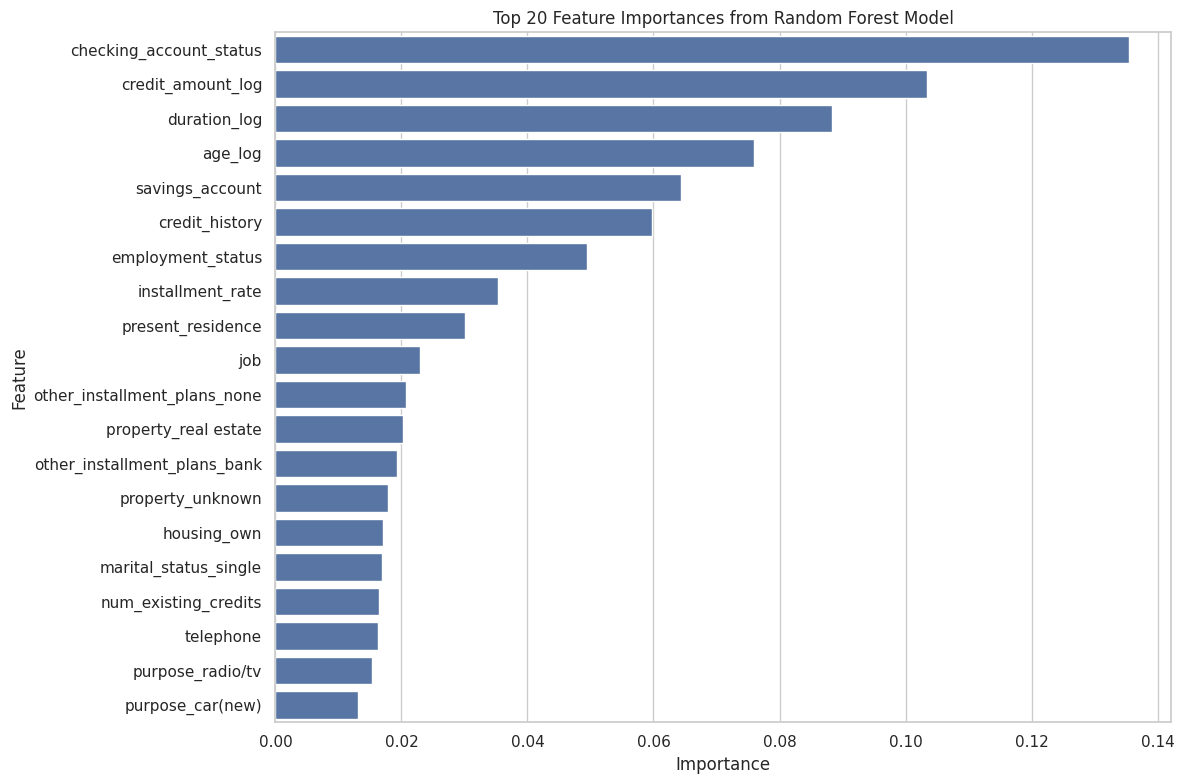

In [72]:
best_rf_model = rf_search.best_estimator_

# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Get feature names (from X_train_scaled columns)
feature_names = X_log_train_scaled.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### XGBoost

In [73]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss",random_state=RANDOM_STATE)

xgb_params = {
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'scale_pos_weight': [1, (np.sum(y_train==0) / np.sum(y_train==1))]  # try default 1 and imbalance ratio
}

xgb_search = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_params,
    n_iter=50,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=n_jobs,
    refit=True
)
xgb_search.fit(X_log_train_scaled, y_train)
print("XGB best roc_auc:", xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGB best roc_auc: 0.80859375
XGB best params: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}


### Feature Importances for XGBoost Model

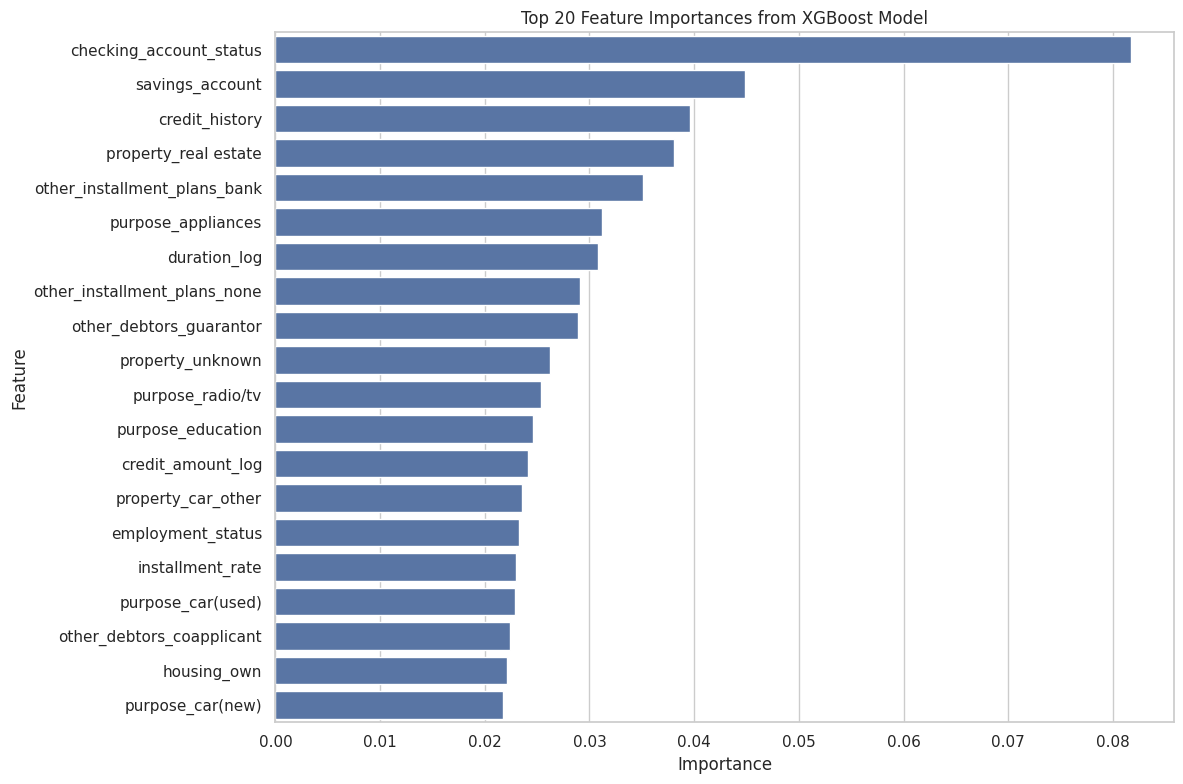

In [74]:
# Get the best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Get feature importances
feature_importances_xgb = best_xgb_model.feature_importances_

# Get feature names
feature_names_xgb = X_log_train_scaled.columns

# Create a DataFrame for better visualization
importance_df_xgb = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': feature_importances_xgb
})

# Sort by importance
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb.head(20))
plt.title('Top 20 Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [76]:
# Retrieve the best KNN model based on the optimal number of neighbors found
best_knn_model = KNeighborsClassifier(n_neighbors=29)

# Collect all best estimators
best_models = {
    'Logistic Regression': log_search.best_estimator_,
    'K-Nearest Neighbors': best_knn_model,
    'Decision Tree': dt_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_
}


def evaluate_on_test_set(models_dict, X_test, y_test):
    """
    Evaluates a dictionary of trained models on a given test set.
    Returns a DataFrame with various metrics for each model.
    """
    results = []
    for name, model in models_dict.items():
        if name == 'K-Nearest Neighbors':
            model.fit(X_log_train_scaled, y_train) # Fit KNN to training data before predicting on test

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Specificity
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0
        else:
            spec = 0.0

        # ROC AUC
        roc = np.nan
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
                roc = roc_auc_score(y_test, y_proba)
            except Exception:
                pass
        elif hasattr(model, "decision_function"):
            try:
                scores = model.decision_function(X_test)
                roc = roc_auc_score(y_test, scores)
            except Exception:
                pass

        results.append({
            'model': name,
            'roc_auc': roc,
            'recall': rec,
            'accuracy': acc,
            'precision': prec,
            'f1': f1,
            'specificity': spec,
        })

    return pd.DataFrame(results).set_index('model').sort_values('roc_auc', ascending=False)

# Evaluate all best models on the final test set
test_metrics = evaluate_on_test_set(best_models, X_log_test_scaled, y_test)
print("Evaluation Metrics of Best Models on Test Set:")
display(test_metrics)

Evaluation Metrics of Best Models on Test Set:


,roc_auc,recall,accuracy,precision,f1,specificity
model,,,,,,
Random Forest,0.804762,0.566667,0.755,0.596491,0.581197,0.835714
XGBoost,0.798333,0.466667,0.770,0.666667,0.549020,0.900000
Logistic Regression,0.793690,0.516667,0.765,0.632653,0.568807,0.871429
K-Nearest Neighbors,0.789881,0.450000,0.780,0.710526,0.551020,0.921429
Decision Tree,0.757738,0.683333,0.700,0.500000,0.577465,0.707143


In [77]:
best_knn_model = KNeighborsClassifier(n_neighbors=22)
best_knn_model.fit(X_log_train_scaled,y_train)

best_models = {
    'Logistic Regression': log_search.best_estimator_,
    'K-Nearest Neighbors': best_knn_model,
    'Decision Tree': dt_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_
}

print("Best models retrieved successfully:")
for name, model in best_models.items():
    print(f"- {name}: {model}")

Best models retrieved successfully:
- Logistic Regression: LogisticRegression(C=0.1, l1_ratio=0.0, max_iter=5000, penalty='elasticnet',
                   random_state=42, solver='saga')
- K-Nearest Neighbors: KNeighborsClassifier(n_neighbors=22)
- Decision Tree: DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_features=0.5,
                       min_samples_leaf=8, min_samples_split=20,
                       random_state=42)
- Random Forest: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_leaf=2,
                       n_estimators=400, n_jobs=1, random_state=42)
- XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
 

## Plot Confusion Matrices for Best Models


--- Confusion Matrix for Logistic Regression ---


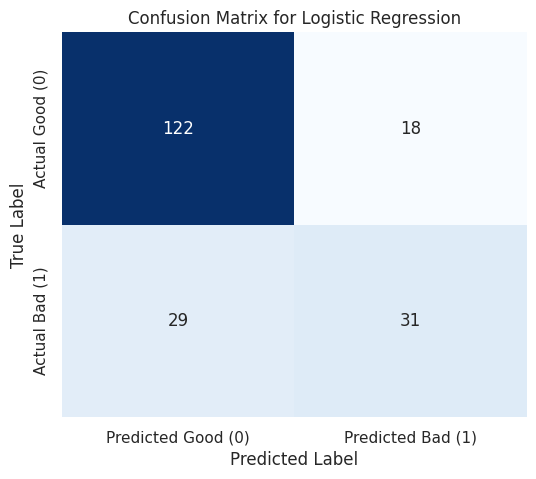


--- Confusion Matrix for K-Nearest Neighbors ---


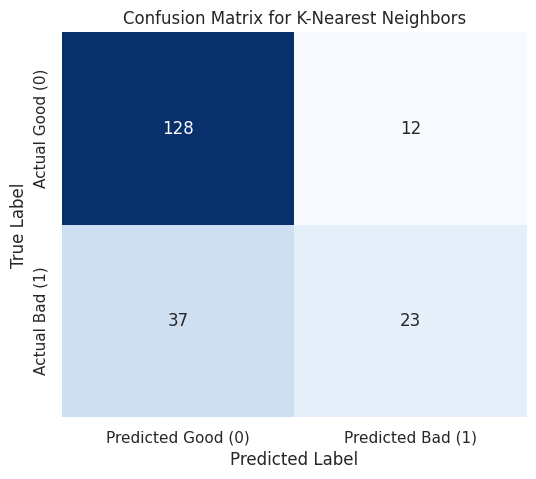


--- Confusion Matrix for Decision Tree ---


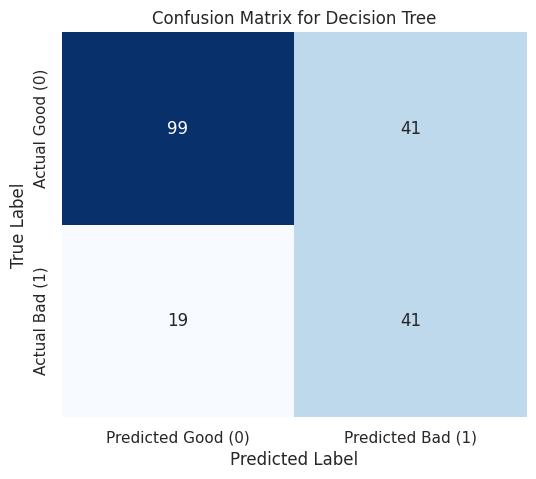


--- Confusion Matrix for Random Forest ---


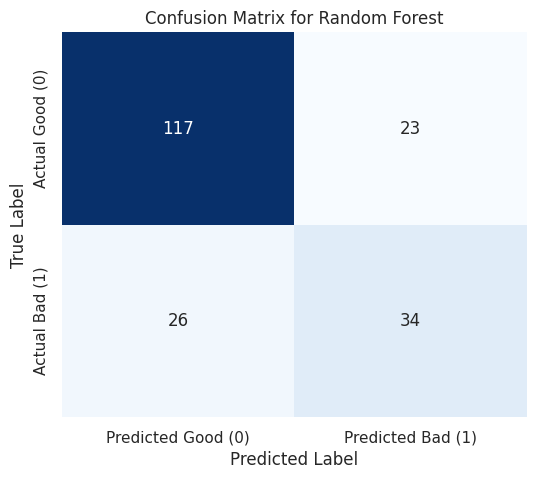


--- Confusion Matrix for XGBoost ---


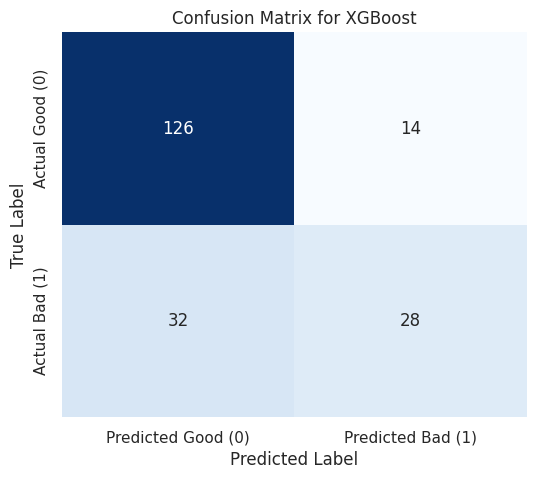

In [78]:
# The plot_confusion_matrix function has already been defined.
# Iterate through the best models and plot their confusion matrices.
for name, model in best_models.items():
    print(f"\n--- Confusion Matrix for {name} ---")
    plot_confusion_matrix(model, X_log_test_scaled, y_test, name)


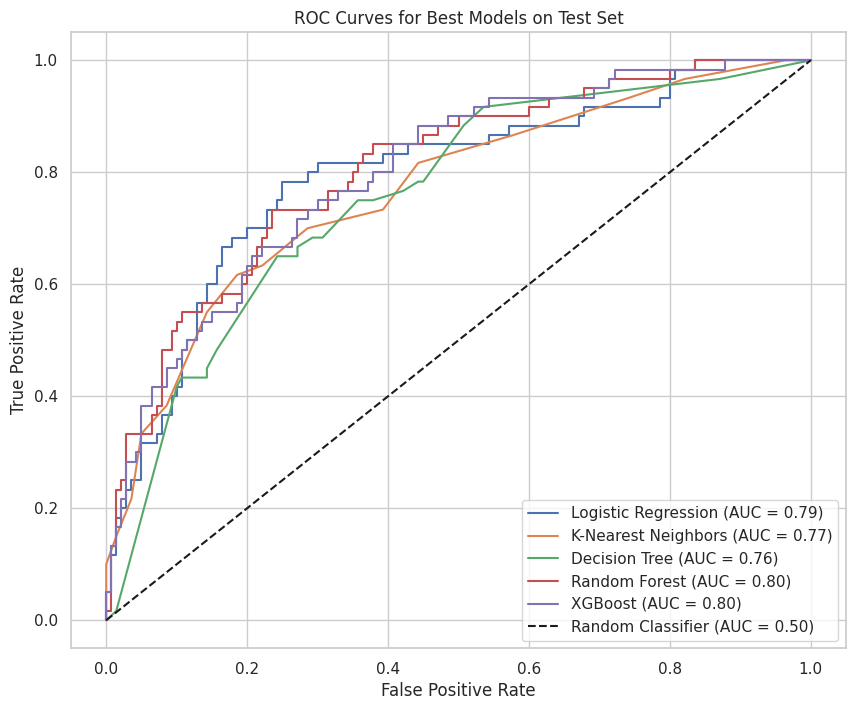

In [79]:
plt.figure(figsize=(10, 8))

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_log_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_log_test_scaled)
    else:
        print(f"Warning: Model {name} does not have predict_proba or decision_function. Skipping ROC curve.")
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Best Models on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()